In [21]:
import pandas as pd
import numpy as np
import csv

# Word Analysis

In [23]:
review = pd.read_csv("Airlines.csv")
review.head(5)

,Airline,Review
0,Delta_Airline,No guarantee of seating if booked on Expedia. ...
1,Delta_Airline,3 days to get to London. Delta are still way b...
2,Delta_Airline,Our trip was from Phoenix to Reno with transit...
3,Delta_Airline,"OUR FLIGHT FROM ST. LOUIS, MO TO ATLANTA, GA. ..."
4,Delta_Airline,My flight to JFK scheduled 2013 was canceled. ...


We scraped reviews from pages that contain discussions for certain airlines. Intuitively, we consider that every review mentions the respective airline name once. Therefore, we attach the respective airline name to each review to make sure we count 1 mentioning of airline, even though the specific review did not mention the airline name.

In [24]:
# attach the airline name to reviews scraped from the airline forum page
data = []
review1 = pd.DataFrame(data)

appended = []
for i in range(len(review)):
    appended.append(review.Airline[i]+" "+review.Review[i])
    
review_concat = pd.Series(appended)
review1.insert(loc = 0,column='review_concat', value=review_concat)
review1.head(5)  # successfully attached

,review_concat
0,Delta_Airline No guarantee of seating if booke...
1,Delta_Airline 3 days to get to London. Delta a...
2,Delta_Airline Our trip was from Phoenix to Ren...
3,"Delta_Airline OUR FLIGHT FROM ST. LOUIS, MO TO..."
4,Delta_Airline My flight to JFK scheduled 2013 ...


## 2.1 Tokenization and replacement

In [25]:
import nltk
# nltk.download('punkt')
from nltk.tokenize import word_tokenize

In [26]:
# users' mentioning of delta can be considered as mentioning of delta airline.
# import a replacement reference created by us to catch those "short names"
replace = pd.read_csv("airline_replace.csv")
replace

,detect,replacement
0,delta,delta_airline
1,united,united_airline
2,spirit,spirit_airline
3,frontier,frontier_airline
4,emirates,emirates_airline
5,southwest,southwest_airline


In [27]:
# show all airline full names
airline_names = review.Airline.unique()
names_lower = []
for i in range(len(airline_names)):
    names_lower.append(airline_names[i].lower())
    
names_lower

['delta_airline',
 'american_airline',
 'united_airline',
 'spirit_airline',
 'air_canada',
 'ryanair',
 'frontier_airline',
 'emirates_airline',
 'southwest_airline',
 'british_airway']

### 2.1.1 replace short names with full names (with underscore but not space)

In [28]:
# tokenize each word/symbols
# replace tokens according to the replacement tabel, except for 'American_airline', 'Air_canada', and 'british_airway',
# for the mentionings of the three airlines may have other meanings
tokenized_replace1 = []
for i in review1["review_concat"]:
    text = word_tokenize(i)
    text1 = []
    for i in range(len(text)):
        text1.append(text[i].lower())
    for j in range(len(text1)):
        if any(text1[j]==replace['detect']):
            airline_name = replace.loc[replace.detect==text1[j],'replacement'].iloc[0]  # replace
            text1[j] = airline_name
    tokenized_replace1.append(text1)

### 2.1.2 replace blurry airline names (Air Canada, American Airlines, and British Airways) with full names  (with underscore but not space)

Since we cannot simply equate the mentioning of "Canada" to the mentioning of "Air Canada", we need to first detect instances of "air" in tokens and check if the next token is "canada". If so, we confirm that the user mentioned "Air Canada" once and replace the mentioning to "air_canada" for later calculation. <br>
Mentionings of "American Airlines" and "British Airways" are processed with the same method due to the same reason. 

In [29]:
tokenized_replace2 = []
for i in range(len(tokenized_replace1)):
    text1 = tokenized_replace1[i]
    for j in range(len(text1)):
        if text1[j].lower()=="air":
            if j < len(text1)-1 and text1[j+1]=="canada":
                text1[j] = "air_canada"
        if text1[j].lower()=="british":
            if j < len(text1)-1 and text1[j+1]=="airways":
                text1[j] = "british_airway"
            elif j < len(text1)-1 and text1[j+1]=="airway":
                text1[j] = "british_airway"
        if text1[j].lower()=="american":
            if j < len(text1)-1 and text1[j+1]=="airlines":
                text1[j] = "american_airline"
            elif j < len(text1)-1 and text1[j+1]=="airline":
                text1[j] = "american_airline" 
    tokenized_replace2.append(text1)

### 2.1.3 Remove duplicate mentions in one review

In [30]:
def remove_duplicate(mylist):  # define a function to help drop replicated airline names
    mylist = list(dict.fromkeys(mylist))
    return mylist

In [31]:
# create a lowercased airline name list for matching
data1 = []
airline_names_df = pd.DataFrame(data1)    
an_series = pd.Series(names_lower)
airline_names_df.insert(loc = 0,column='airline_names', value=an_series)
airline_names_df 

,airline_names
0,delta_airline
1,american_airline
2,united_airline
3,spirit_airline
4,air_canada
5,ryanair
6,frontier_airline
7,emirates_airline
8,southwest_airline
9,british_airway


In [32]:
# make sure to have only one airline mentionings in one post
airline_mentioned = []
for sent in tokenized_replace2:
    airline_post=[]
    for m in range(len(sent)):
        if any(sent[m]==airline_names_df["airline_names"]):
            airline_post.append(sent[m])
    if airline_post != []: # only append non-empty lists
        airline_post = remove_duplicate(airline_post)
        airline_mentioned.append(airline_post)

## 2.2 Count airline name mentionings

In [33]:
# count airline mentionings into a dictionary
airline_count_dict = {}
for i in names_lower:
    count = 0
    for j in airline_mentioned:
        if i in j:
            count +=1
    airline_count_dict[i] = count
    
airline_count_df = pd.DataFrame(list(airline_count_dict.items()),columns = ['Airline','Count'])
airline_count_df = airline_count_df.sort_values(by=['Count'],ascending=False)
airline_count_df

,Airline,Count
2,united_airline,2245
0,delta_airline,2234
8,southwest_airline,2173
1,american_airline,2155
5,ryanair,2086
7,emirates_airline,2085
3,spirit_airline,2053
9,british_airway,2035
4,air_canada,2023
6,frontier_airline,2022


In [34]:
# bar plot of top 10 brands
import matplotlib.pyplot as plt
import seaborn as sns

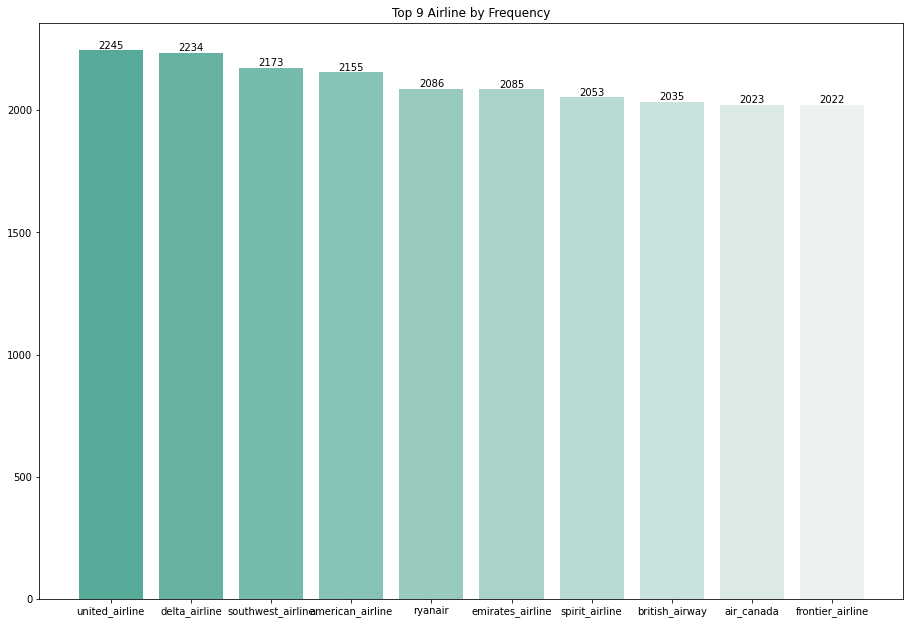

In [35]:
fig = plt.figure()    # initiate a figure
ax = fig.add_axes([5,5,2,2])    #  set up plot size and axes
k = ax.bar(airline_count_df['Airline'],airline_count_df['Count'],color = sns.color_palette('light:#5A9_r',10))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Top 9 Airline by Frequency')
plt.show()

## 2.3 Word frequency

In [36]:
from __future__ import division
import nltk, re
nltk.download('averaged_perceptron_tagger')
from nltk import FreqDist
from nltk import word_tokenize 
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import brown 

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ziyezhang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [37]:
# tag tokenized original reviews with part-of-speech tags

total=[]
for i in review["Review"]:
    text = word_tokenize(i)
    total.append(text)
    
tagged = nltk.pos_tag_sents(total)

In [38]:
# count the most frequently mentioned nouns, adjectives, and adverbs
# record the words of selected part-of-speech type

def containsNumber(value):  # remove words that contain numbers 
    for character in value:
        if character.isdigit():
            return True
    return False

words_recorder = []

for i in range(len(tagged)): 
    tag_select = tagged[i]
    for j in range(len(tag_select)):
        label = tag_select[j][1]
        word = tag_select[j][0]
        if label in ['NN', 'JJ', 'JJR', 'JJS', 'NNS', 'NNP', 'NNPS', 'RB', 'RBR', 'RBS']:
            if containsNumber(word) == False:
                words_recorder.append(word.lower())
        
words_recorder

['guarantee',
 'expedia',
 'daughter',
 'cousins',
 'grandmother',
 'away',
 'not',
 'even',
 'were',
 'less',
 'nice',
 'delta',
 'only',
 'lot',
 'years',
 'airline',
 'days',
 'london',
 'delta',
 'still',
 'way',
 'bar',
 'service',
 'ceo',
 'so',
 'many',
 'aspects',
 'business',
 'however',
 'customer',
 'care',
 'worst',
 'industry',
 'second',
 'day',
 'jfk',
 'atc',
 'delta',
 "n't",
 'comp',
 'help',
 'line',
 'once',
 'again',
 'times',
 'remember',
 'atlanta',
 'few',
 'months',
 'ago',
 'once',
 'phone',
 'poorly',
 'trained',
 'telephonists',
 'idea',
 'stress',
 'indeed',
 'upset',
 'one',
 'trip',
 'phoenix',
 'transit',
 'salt',
 'lake',
 'city',
 'originally',
 'fly',
 'slc',
 'next',
 'flight',
 'delta',
 'flight',
 'slc',
 'arrived',
 'due',
 'technical',
 'issues',
 'not',
 'flight',
 'schedule',
 'next',
 'flight',
 'hours',
 'our',
 'flight',
 'from',
 'st.',
 'louis',
 'mo',
 'to',
 'atlanta',
 'ga.',
 'to',
 'celebrate',
 'our',
 'anniversary',
 'husband',
 'fl

In [39]:
# the 500 most frequently mentioned words
from collections import Counter
c = Counter(words_recorder)
c_500 = c.most_common(500)

common_words = []
for i in c_500:
    word = i[0]
    common_words.append(word)
    
common_words_df = pd.DataFrame(common_words,columns = ['Word'])
common_words_df.head(10)

,Word
0,flight
1,not
2,n't
3,time
4,service
5,very
6,airline
7,airlines
8,so
9,plane


In [40]:
# import os    
# common_words_df.to_csv('freq.csv')  

In [41]:
attri = pd.read_csv("freq.csv")
attri

,Category,Attribute
0,comfort,seat
1,comfort,seats
2,comfort,leg
3,comfort,comfortable
4,comfort,room
...,...,...
171,food_beverage,sweets
172,food_beverage,fruits
173,food_beverage,cake
174,food_beverage,cakes


In [42]:
# tokenize each word/symbols, and at the same time replace any detected attribute with attribute category
tokenized_attr = []
for i in review["Review"]:
    text = word_tokenize(i)
    for j in range(len(text)):
        if any(text[j]==attri['Attribute']):
            category = attri.loc[attri.Attribute==text[j],'Category'].iloc[0]
            text[j] = category
    tokenized_attr.append(text)

In [43]:
# append lowercased tokens to a list
attr_mentioned = []
for sent in tokenized_attr:
    attr_post=[]
    for m in range(len(sent)):
        if any(sent[m].lower()==attri['Category']):
            attr_post.append(sent[m].lower())
    if attr_post != []:# only append non-empty lists
        attr_post = remove_duplicate(attr_post)
        attr_mentioned.append(attr_post)
          
attr_mentioned

[['comfort'],
 ['check-in_boarding', 'customer_service', 'monetary_values'],
 ['check-in_boarding'],
 ['check-in_boarding', 'monetary_values'],
 ['comfort', 'check-in_boarding', 'monetary_values'],
 ['cleanliness', 'customer_service', 'check-in_boarding', 'comfort'],
 ['customer_service'],
 ['check-in_boarding', 'customer_service'],
 ['check-in_boarding', 'monetary_values', 'customer_service'],
 ['monetary_values', 'check-in_boarding'],
 ['check-in_boarding',
  'food_beverage',
  'in-flight_entertainment',
  'comfort',
  'monetary_values'],
 ['monetary_values', 'comfort'],
 ['check-in_boarding', 'customer_service'],
 ['customer_service', 'monetary_values', 'check-in_boarding'],
 ['customer_service', 'monetary_values', 'comfort', 'check-in_boarding'],
 ['customer_service', 'check-in_boarding', 'monetary_values'],
 ['customer_service'],
 ['monetary_values', 'customer_service'],
 ['monetary_values', 'check-in_boarding', 'customer_service'],
 ['check-in_boarding', 'customer_service', 'mone

In [44]:
# count attribute mentionings
attrs =  attri['Category'].unique()
attr_count_dict = {}
for i in attrs:
    count = 0
    for j in attr_mentioned:
        if i in j:
            count +=1
    attr_count_dict[i] = count

In [45]:
# sort the counts, display the popularity of attributes
attr_count_df = pd.DataFrame(list(attr_count_dict.items()),columns = ['Attribute Catgory','Count'])
attr_count_df = attr_count_df.sort_values(by=["Count"], ascending = False, ignore_index = True) 
attr_count_df

,Attribute Catgory,Count
0,check-in_boarding,16956
1,customer_service,14411
2,monetary_values,11603
3,comfort,7587
4,food_beverage,4664
5,in-flight_entertainment,1883
6,cleanliness,1042


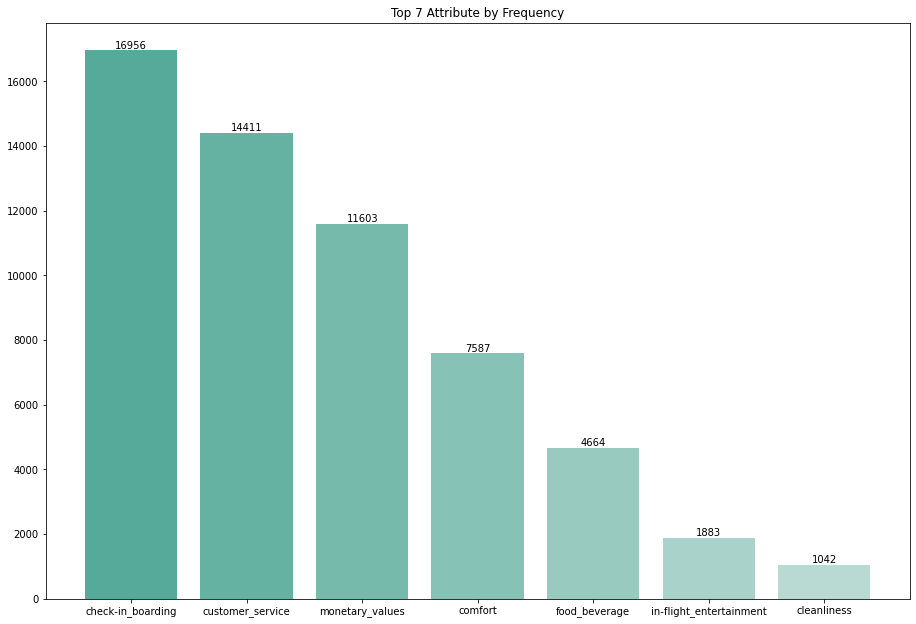

In [46]:
fig = plt.figure()    # initiate a figure
ax = fig.add_axes([5,5,2,2])    #  set up plot size and axes
k = ax.bar(attr_count_df['Attribute Catgory'],attr_count_df['Count'],color = sns.color_palette('light:#5A9_r',10))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Top 7 Attribute by Frequency')
plt.show()

Get mentionings of airlines and attributes without dropping empty lists
We hope to one-on-one match airline mentionings and attribute mentionings of each post, then drop the posts mentioned neither airline nor attribute. So, we first keep the empty lists to make sure the rows(indexes) of airline and attribute mentionings match with each other.

In [47]:
air_mentioned_with_empty = []
for sent in tokenized_replace2:
    air_post = []
    for m in range(len(sent)):
        if any(sent[m].lower()==airline_names_df["airline_names"]):
            air_post.append(sent[m].lower())
        air_post = remove_duplicate(air_post)
    air_mentioned_with_empty.append(air_post)  # append both empty and non-empty lists

air_mentioned_with_empty

[['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline', 'american_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],
 ['delta_airline'],


In [48]:
attr_mentioned_with_empty = []
for sent in tokenized_attr:
    attr_post = []
    for m in range(len(sent)):
        if any(sent[m].lower()==attri['Category']):
            attr_post.append(sent[m].lower())
        attr_post = remove_duplicate(attr_post)
    attr_mentioned_with_empty.append(attr_post)  # append both empty and non-empty lists

attr_mentioned_with_empty

[['comfort'],
 ['check-in_boarding', 'customer_service', 'monetary_values'],
 ['check-in_boarding'],
 ['check-in_boarding', 'monetary_values'],
 ['comfort', 'check-in_boarding', 'monetary_values'],
 ['cleanliness', 'customer_service', 'check-in_boarding', 'comfort'],
 ['customer_service'],
 ['check-in_boarding', 'customer_service'],
 ['check-in_boarding', 'monetary_values', 'customer_service'],
 ['monetary_values', 'check-in_boarding'],
 ['check-in_boarding',
  'food_beverage',
  'in-flight_entertainment',
  'comfort',
  'monetary_values'],
 ['monetary_values', 'comfort'],
 ['check-in_boarding', 'customer_service'],
 ['customer_service', 'monetary_values', 'check-in_boarding'],
 ['customer_service', 'monetary_values', 'comfort', 'check-in_boarding'],
 ['customer_service', 'check-in_boarding', 'monetary_values'],
 ['customer_service'],
 ['monetary_values', 'customer_service'],
 ['monetary_values', 'check-in_boarding', 'customer_service'],
 ['check-in_boarding', 'customer_service', 'mone

In [49]:
len(air_mentioned_with_empty) == len(attr_mentioned_with_empty)

True

In [50]:
#putting airline names and attributes together
data = []
df_airline_attri = pd.DataFrame(data)

In [51]:
airline_mentioned = pd.Series(air_mentioned_with_empty)
attri_mentioned = pd.Series(attr_mentioned_with_empty)
df_airline_attri.insert(loc = 0,column='Airline_Mentioned', value=airline_mentioned)
df_airline_attri.insert(loc = 1, column='Attribute_Mentioned', value=attri_mentioned)
df_airline_attri_null_copy = df_airline_attri.copy()

In [52]:
import numpy as np
df_airline_attri.Airline_Mentioned = df_airline_attri.Airline_Mentioned.apply(lambda Airline_Mentioned: np.nan if len(Airline_Mentioned)==0 
                                                                      else Airline_Mentioned)
df_airline_attri.Attribute_Mentioned = df_airline_attri.Attribute_Mentioned.apply(lambda Attribute_Mentioned: np.nan if len(Attribute_Mentioned)==0 
                                                                      else Attribute_Mentioned)
df_airline_attri

,Airline_Mentioned,Attribute_Mentioned
0,[delta_airline],[comfort]
1,[delta_airline],"[check-in_boarding, customer_service, monetary..."
2,[delta_airline],[check-in_boarding]
3,[delta_airline],"[check-in_boarding, monetary_values]"
4,[delta_airline],"[comfort, check-in_boarding, monetary_values]"
...,...,...
19995,[british_airway],"[check-in_boarding, customer_service, comfort,..."
19996,[british_airway],[customer_service]
19997,[british_airway],"[comfort, cleanliness, customer_service, food_..."
19998,[british_airway],[customer_service]


In [53]:
# exclude posts that mentioned neither attributs nor airline names
df_airline_attri_final = df_airline_attri[df_airline_attri['Airline_Mentioned'].notna()]
df_airline_attri_final = df_airline_attri[df_airline_attri['Attribute_Mentioned'].notna()]
df_airline_attri_final

,Airline_Mentioned,Attribute_Mentioned
0,[delta_airline],[comfort]
1,[delta_airline],"[check-in_boarding, customer_service, monetary..."
2,[delta_airline],[check-in_boarding]
3,[delta_airline],"[check-in_boarding, monetary_values]"
4,[delta_airline],"[comfort, check-in_boarding, monetary_values]"
...,...,...
19995,[british_airway],"[check-in_boarding, customer_service, comfort,..."
19996,[british_airway],[customer_service]
19997,[british_airway],"[comfort, cleanliness, customer_service, food_..."
19998,[british_airway],[customer_service]


In [54]:
import os  
#os.makedirs('C:/YICHEN WANG/Course/2022 WINTER/INSY 669/ASSIGNMENT/assignment2', exist_ok=True)  
#df_airline_attri_final.to_csv('C:/YICHEN WANG/Course/2022 WINTER/INSY 669/ASSIGNMENT/assignment2/df_airline_attri_final.csv')  

# 3. Sentiment Analysis with VADER

In [55]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [56]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ziyezhang/nltk_data...


True

In [37]:
review_sent = review

In [38]:
SIA = SentimentIntensityAnalyzer()

review_sent['scores'] = review_sent['Review'].apply(lambda Review: SIA.polarity_scores(Review))

review_sent.head(5)

,Airline,Review,scores
0,Delta_Airline,No guarantee of seating if booked on Expedia. ...,"{'neg': 0.036, 'neu': 0.889, 'pos': 0.074, 'co..."
1,Delta_Airline,3 days to get to London. Delta are still way b...,"{'neg': 0.125, 'neu': 0.79, 'pos': 0.086, 'com..."
2,Delta_Airline,Our trip was from Phoenix to Reno with transit...,"{'neg': 0.058, 'neu': 0.942, 'pos': 0.0, 'comp..."
3,Delta_Airline,"OUR FLIGHT FROM ST. LOUIS, MO TO ATLANTA, GA. ...","{'neg': 0.0, 'neu': 0.953, 'pos': 0.047, 'comp..."
4,Delta_Airline,My flight to JFK scheduled 2013 was canceled. ...,"{'neg': 0.062, 'neu': 0.894, 'pos': 0.044, 'co..."


In [39]:
review_sent['compound']  = review_sent['scores'].apply(lambda score_dict: score_dict['compound'])
review_sent['sent_type'] = review_sent['compound'].apply(lambda c: 2 if c>0 else (1 if c==0 else 0))

# sent_type == 0: negative (compound < 0)
# sent_type == 1: neutral (compound = 0)
# sent_type == 2: positive (compound > 0)

review_sent.head(5)

,Airline,Review,scores,compound,sent_type
0,Delta_Airline,No guarantee of seating if booked on Expedia. ...,"{'neg': 0.036, 'neu': 0.889, 'pos': 0.074, 'co...",0.3230,2
1,Delta_Airline,3 days to get to London. Delta are still way b...,"{'neg': 0.125, 'neu': 0.79, 'pos': 0.086, 'com...",-0.6641,0
2,Delta_Airline,Our trip was from Phoenix to Reno with transit...,"{'neg': 0.058, 'neu': 0.942, 'pos': 0.0, 'comp...",-0.4767,0
3,Delta_Airline,"OUR FLIGHT FROM ST. LOUIS, MO TO ATLANTA, GA. ...","{'neg': 0.0, 'neu': 0.953, 'pos': 0.047, 'comp...",0.7804,2
4,Delta_Airline,My flight to JFK scheduled 2013 was canceled. ...,"{'neg': 0.062, 'neu': 0.894, 'pos': 0.044, 'co...",-0.5186,0


In [40]:
review_sent["Airline_Mentioned"] = df_airline_attri_null_copy["Airline_Mentioned"]
review_sent["Attribute_Mentioned"] = df_airline_attri_null_copy["Attribute_Mentioned"]

In [41]:
review_sent

,Airline,Review,scores,compound,sent_type,Airline_Mentioned,Attribute_Mentioned
0,Delta_Airline,No guarantee of seating if booked on Expedia. ...,"{'neg': 0.036, 'neu': 0.889, 'pos': 0.074, 'co...",0.3230,2,[delta_airline],[comfort]
1,Delta_Airline,3 days to get to London. Delta are still way b...,"{'neg': 0.125, 'neu': 0.79, 'pos': 0.086, 'com...",-0.6641,0,[delta_airline],"[check-in_boarding, customer_service, monetary..."
2,Delta_Airline,Our trip was from Phoenix to Reno with transit...,"{'neg': 0.058, 'neu': 0.942, 'pos': 0.0, 'comp...",-0.4767,0,[delta_airline],[check-in_boarding]
3,Delta_Airline,"OUR FLIGHT FROM ST. LOUIS, MO TO ATLANTA, GA. ...","{'neg': 0.0, 'neu': 0.953, 'pos': 0.047, 'comp...",0.7804,2,[delta_airline],"[check-in_boarding, monetary_values]"
4,Delta_Airline,My flight to JFK scheduled 2013 was canceled. ...,"{'neg': 0.062, 'neu': 0.894, 'pos': 0.044, 'co...",-0.5186,0,[delta_airline],"[comfort, check-in_boarding, monetary_values]"
...,...,...,...,...,...,...,...
19995,British_Airway,LGW-MCO-LGW 11-25th August Economy Class. Got ...,"{'neg': 0.103, 'neu': 0.837, 'pos': 0.06, 'com...",-0.5305,0,[british_airway],"[check-in_boarding, customer_service, comfort,..."
19996,British_Airway,✅ Verified Review | Flew London Heathrow to C...,"{'neg': 0.108, 'neu': 0.873, 'pos': 0.019, 'co...",-0.7876,0,[british_airway],[customer_service]
19997,British_Airway,LHR-SFO-LHR. Missed out on the A380 and both l...,"{'neg': 0.127, 'neu': 0.696, 'pos': 0.177, 'co...",0.8539,2,[british_airway],"[comfort, cleanliness, customer_service, food_..."
19998,British_Airway,✅ Trip Verified | London to Calgary. Thank yo...,"{'neg': 0.0, 'neu': 0.732, 'pos': 0.268, 'comp...",0.8718,2,[british_airway],[customer_service]


In [42]:
for j in airline_names_df["airline_names"]:
    temp_airline = []
    for i in review_sent["Airline_Mentioned"]:
        if j in i:
            temp_airline.append(1)
        else:
            temp_airline.append(0)
    temp_airline = pd.Series(temp_airline)
    review_sent[j] = temp_airline

top_attri = ["comfort","in-flight_entertainment","customer_service",
             "monetary_values","cleanliness","check-in_boarding","food_beverage"]
for j in top_attri:
    temp_attri = []
    for i in review_sent["Attribute_Mentioned"]:
        if j in i:
            temp_attri.append(1)
        else:
            temp_attri.append(0)
    temp_attri = pd.Series(temp_attri)
    review_sent[j] = temp_attri

In [43]:
review_sent=review_sent.drop(columns="Review")

In [44]:
#os.makedirs('C:/YICHEN WANG/Course/2022 WINTER/INSY 669/ASSIGNMENT/assignment2', exist_ok=True)  
#review_sent.to_csv('C:/YICHEN WANG/Course/2022 WINTER/INSY 669/ASSIGNMENT/assignment2/sentiment_airline.csv')  

In [184]:
import pandas as pd

senti_scores = pd.read_csv('sentiment_airline.csv',index_col=0)

In [46]:
senti_scores
senti_mean = pd.DataFrame(senti_scores.groupby('Airline')['compound'].mean())
senti_mean = senti_mean.sort_values(by=['compound'])
senti_mean

,compound
Airline,
American_Airline,-0.311735
Frontier_Airline,-0.267576
Spirit_Airline,-0.242824
Delta_Airline,-0.143534
Air_Canada,-0.065919
United_Airline,-0.038875
Ryanair,0.002468
Southwest_Airline,0.183849
British_Airway,0.215349


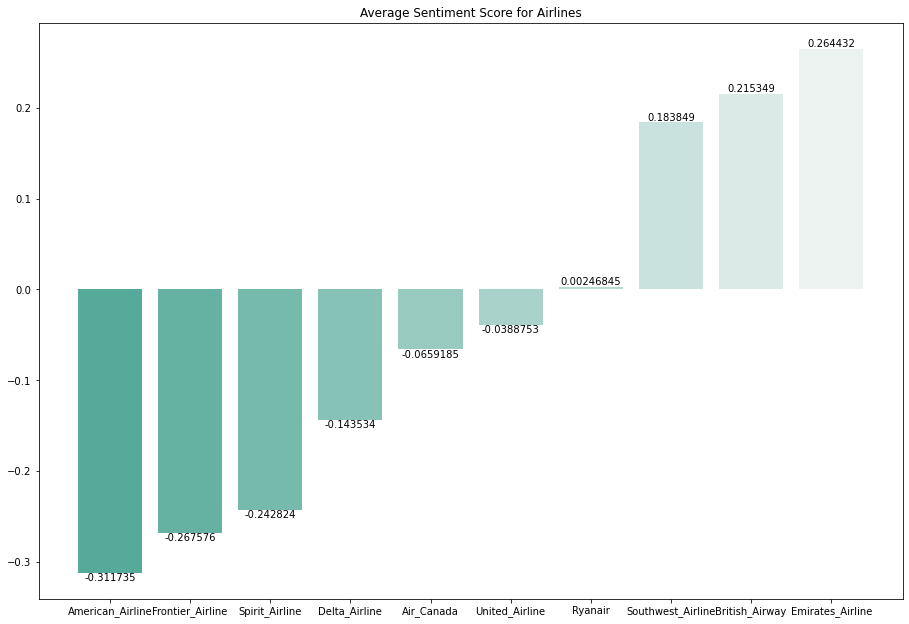

In [47]:
fig = plt.figure()    # initiate a figure
ax = fig.add_axes([5,5,2,2])    #  set up plot size and axes
k = ax.bar(senti_mean.index,senti_mean['compound'],color = sns.color_palette('light:#5A9_r',10))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Average Sentiment Score for Airlines')
plt.show()

In [188]:
y = senti_scores[['compound']]

X = senti_scores.drop(['Airline','scores','compound','sent_type','Airline_Mentioned','Attribute_Mentioned'],axis=1)

import statsmodels.api as sm
mod = sm.OLS(endog = y , exog = X )
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:               compound   R-squared (uncentered):                   0.105
Model:                            OLS   Adj. R-squared (uncentered):              0.104
Method:                 Least Squares   F-statistic:                              138.0
Date:                Tue, 15 Feb 2022   Prob (F-statistic):                        0.00
Time:                        20:45:14   Log-Likelihood:                         -20842.
No. Observations:               20000   AIC:                                  4.172e+04
Df Residuals:                   19983   BIC:                                  4.185e+04
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

# 4. Lift Analysis

In [49]:
airline_count_df = airline_count_df.sort_values('Count', ascending=False)
airline_count_df = airline_count_df.reset_index().drop(["index"], axis=1)
airline_count_df

,Airline,Count
0,united_airline,2245
1,delta_airline,2234
2,southwest_airline,2173
3,american_airline,2155
4,ryanair,2086
5,emirates_airline,2085
6,spirit_airline,2053
7,british_airway,2035
8,air_canada,2023
9,frontier_airline,2022


In [50]:
# exclude airline that has no co-mentions with some other airlines
airline_count_df = airline_count_df.iloc[:9,]
airline_count_df

,Airline,Count
0,united_airline,2245
1,delta_airline,2234
2,southwest_airline,2173
3,american_airline,2155
4,ryanair,2086
5,emirates_airline,2085
6,spirit_airline,2053
7,british_airway,2035
8,air_canada,2023


## 4.1 Lift ratio between airlines

In [51]:
airline_lift_array = np.empty((len(airline_count_df),len(airline_count_df)))
airline_lift_array[:] = np.NaN

In [52]:
N = len(review) # total number of reviews
N

20000

In [53]:
for i in range(len(airline_count_df)): 
    airline1 = airline_count_df['Airline'][i]
    airline1_count =  airline_count_df['Count'][i] # number of reviews containing airline 1
    
    for j in range(i+1, len(airline_count_df)):
        airline2 = airline_count_df['Airline'][j]
        airline2_count = airline_count_df['Count'][j] # number of reviews containing airline 2
        
        airline1_2_count = 0 # initialize the number of reviews containing both airline 1 and 2
        for airlines in airline_mentioned:
            if airline1 in airlines and airline2 in airlines:
                airline1_2_count += 1
                
        airline_lift = N*airline1_2_count/(airline1_count*airline2_count) # calculate lift
        airline_lift_array[i,j] = airline_lift

In [54]:
airline_lift_array = np.round(airline_lift_array, decimals=3)
airline_lift_array

array([[  nan, 0.427, 0.258, 0.372, 0.026, 0.038, 0.161, 0.053, 0.308],
       [  nan,   nan, 0.284, 0.378, 0.009, 0.047, 0.17 , 0.035, 0.071],
       [  nan,   nan,   nan, 0.248, 0.022, 0.004, 0.184, 0.005, 0.005],
       [  nan,   nan,   nan,   nan, 0.009, 0.053, 0.118, 0.169, 0.096],
       [  nan,   nan,   nan,   nan,   nan, 0.046, 0.009, 0.405, 0.019],
       [  nan,   nan,   nan,   nan,   nan,   nan, 0.005, 0.382, 0.019],
       [  nan,   nan,   nan,   nan,   nan,   nan,   nan, 0.014, 0.005],
       [  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan, 0.097],
       [  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan]])

In [55]:
airline_dissimi_array = 1/airline_lift_array # calculate dissimilarity for MDS plot
np.nan_to_num(airline_dissimi_array, copy=False, nan=0.0)
airline_dissimi_array = airline_dissimi_array + airline_dissimi_array.T  # fill the lower triangular part
airline_dissimi_array = np.round(airline_dissimi_array, decimals=3)
airline_dissimi_array

array([[  0.   ,   2.342,   3.876,   2.688,  38.462,  26.316,   6.211,
         18.868,   3.247],
       [  2.342,   0.   ,   3.521,   2.646, 111.111,  21.277,   5.882,
         28.571,  14.085],
       [  3.876,   3.521,   0.   ,   4.032,  45.455, 250.   ,   5.435,
        200.   , 200.   ],
       [  2.688,   2.646,   4.032,   0.   , 111.111,  18.868,   8.475,
          5.917,  10.417],
       [ 38.462, 111.111,  45.455, 111.111,   0.   ,  21.739, 111.111,
          2.469,  52.632],
       [ 26.316,  21.277, 250.   ,  18.868,  21.739,   0.   , 200.   ,
          2.618,  52.632],
       [  6.211,   5.882,   5.435,   8.475, 111.111, 200.   ,   0.   ,
         71.429, 200.   ],
       [ 18.868,  28.571, 200.   ,   5.917,   2.469,   2.618,  71.429,
          0.   ,  10.309],
       [  3.247,  14.085, 200.   ,  10.417,  52.632,  52.632, 200.   ,
         10.309,   0.   ]])

In [56]:
airline_lift_df = pd.DataFrame(data=airline_lift_array, index=airline_count_df['Airline'], columns=airline_count_df['Airline'])
airline_lift_df

Airline,united_airline,delta_airline,southwest_airline,american_airline,ryanair,emirates_airline,spirit_airline,british_airway,air_canada
Airline,,,,,,,,,
united_airline,NaN,0.427,0.258,0.372,0.026,0.038,0.161,0.053,0.308
delta_airline,NaN,NaN,0.284,0.378,0.009,0.047,0.170,0.035,0.071
southwest_airline,NaN,NaN,NaN,0.248,0.022,0.004,0.184,0.005,0.005
american_airline,NaN,NaN,NaN,NaN,0.009,0.053,0.118,0.169,0.096
ryanair,NaN,NaN,NaN,NaN,NaN,0.046,0.009,0.405,0.019
emirates_airline,NaN,NaN,NaN,NaN,NaN,NaN,0.005,0.382,0.019
spirit_airline,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014,0.005
british_airway,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.097
air_canada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Heatmap of Airline-Airline Lift'}, xlabel='Airline', ylabel='Airline'>

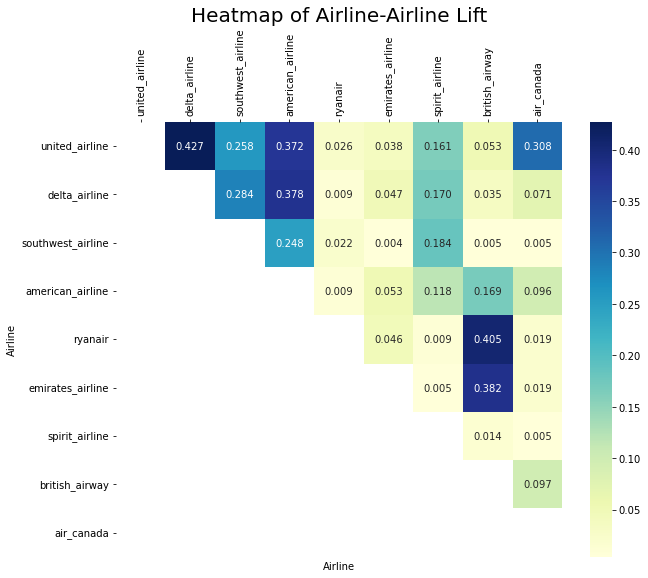

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,8))
plt.title('Heatmap of Airline-Airline Lift', fontsize = 20)
ax.xaxis.tick_top()
sns.heatmap(airline_lift_df, cmap = "YlGnBu", annot = True, fmt='.3f')

In [58]:
airline_dissimi_df = pd.DataFrame(data=airline_dissimi_array, index=airline_count_df['Airline'], columns=airline_count_df['Airline'])
airline_dissimi_df

Airline,united_airline,delta_airline,southwest_airline,american_airline,ryanair,emirates_airline,spirit_airline,british_airway,air_canada
Airline,,,,,,,,,
united_airline,0.000,2.342,3.876,2.688,38.462,26.316,6.211,18.868,3.247
delta_airline,2.342,0.000,3.521,2.646,111.111,21.277,5.882,28.571,14.085
southwest_airline,3.876,3.521,0.000,4.032,45.455,250.000,5.435,200.000,200.000
american_airline,2.688,2.646,4.032,0.000,111.111,18.868,8.475,5.917,10.417
ryanair,38.462,111.111,45.455,111.111,0.000,21.739,111.111,2.469,52.632
emirates_airline,26.316,21.277,250.000,18.868,21.739,0.000,200.000,2.618,52.632
spirit_airline,6.211,5.882,5.435,8.475,111.111,200.000,0.000,71.429,200.000
british_airway,18.868,28.571,200.000,5.917,2.469,2.618,71.429,0.000,10.309
air_canada,3.247,14.085,200.000,10.417,52.632,52.632,200.000,10.309,0.000


<AxesSubplot:title={'center':'Heatmap of Airline-Airline Dissimilarity'}, xlabel='Airline', ylabel='Airline'>

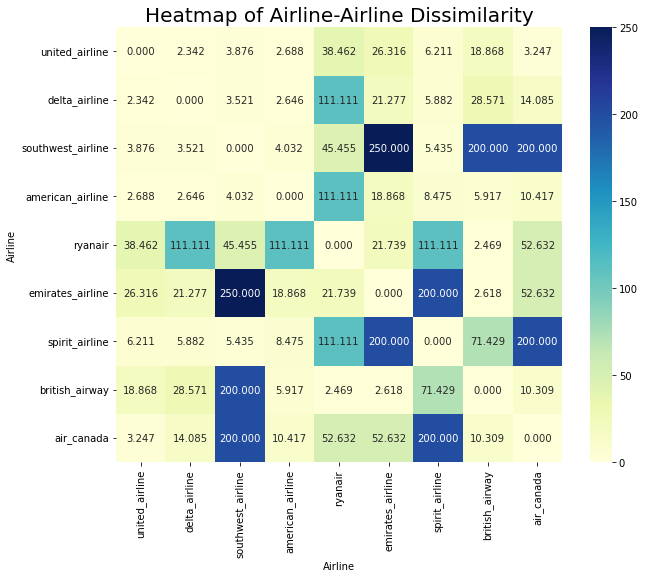

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,8))
plt.title('Heatmap of Airline-Airline Dissimilarity', fontsize = 20)
sns.heatmap(airline_dissimi_df, cmap = "YlGnBu", annot = True, fmt='.3f')

## 4.2 Lift ratio between airlines and attributes

In [60]:
airline_count_df

,Airline,Count
0,united_airline,2245
1,delta_airline,2234
2,southwest_airline,2173
3,american_airline,2155
4,ryanair,2086
5,emirates_airline,2085
6,spirit_airline,2053
7,british_airway,2035
8,air_canada,2023


In [61]:
attr_count_df

,Attribute Catgory,Count
0,check-in_boarding,16956
1,customer_service,14411
2,monetary_values,11603
3,comfort,7587
4,food_beverage,4664
5,in-flight_entertainment,1883
6,cleanliness,1042


In [62]:
airline_attri_list = pd.concat([airline_count_df.rename(columns={'Airline':'Word'}), 
                                    attr_count_df.rename(columns={'Attribute Catgory':'Word'})], 
                                   ignore_index=True)
airline_attri_list

,Word,Count
0,united_airline,2245
1,delta_airline,2234
2,southwest_airline,2173
3,american_airline,2155
4,ryanair,2086
5,emirates_airline,2085
6,spirit_airline,2053
7,british_airway,2035
8,air_canada,2023
9,check-in_boarding,16956


In [63]:
df_airline_attri_final

,Airline_Mentioned,Attribute_Mentioned
0,[delta_airline],[comfort]
1,[delta_airline],"[check-in_boarding, customer_service, monetary..."
2,[delta_airline],[check-in_boarding]
3,[delta_airline],"[check-in_boarding, monetary_values]"
4,[delta_airline],"[comfort, check-in_boarding, monetary_values]"
...,...,...
19995,[british_airway],"[check-in_boarding, customer_service, comfort,..."
19996,[british_airway],[customer_service]
19997,[british_airway],"[comfort, cleanliness, customer_service, food_..."
19998,[british_airway],[customer_service]


In [64]:
df_airline_attri_final['Merge'] = df_airline_attri_final['Airline_Mentioned'] + df_airline_attri_final['Attribute_Mentioned']
df_airline_attri_final

C:\Users\DELL\AppData\Local\Temp/ipykernel_78868/3629058009.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_airline_attri_final['Merge'] = df_airline_attri_final['Airline_Mentioned'] + df_airline_attri_final['Attribute_Mentioned']


,Airline_Mentioned,Attribute_Mentioned,Merge
0,[delta_airline],[comfort],"[delta_airline, comfort]"
1,[delta_airline],"[check-in_boarding, customer_service, monetary...","[delta_airline, check-in_boarding, customer_se..."
2,[delta_airline],[check-in_boarding],"[delta_airline, check-in_boarding]"
3,[delta_airline],"[check-in_boarding, monetary_values]","[delta_airline, check-in_boarding, monetary_va..."
4,[delta_airline],"[comfort, check-in_boarding, monetary_values]","[delta_airline, comfort, check-in_boarding, mo..."
...,...,...,...
19995,[british_airway],"[check-in_boarding, customer_service, comfort,...","[british_airway, check-in_boarding, customer_s..."
19996,[british_airway],[customer_service],"[british_airway, customer_service]"
19997,[british_airway],"[comfort, cleanliness, customer_service, food_...","[british_airway, comfort, cleanliness, custome..."
19998,[british_airway],[customer_service],"[british_airway, customer_service]"


In [65]:
airline_attr_lift_array = np.empty((len(airline_attri_list),len(airline_attri_list)))
airline_attr_lift_array[:] = np.NaN

In [66]:
N = len(review) # total number of reviews
N

20000

In [67]:
for i in range(len(airline_attri_list)): 
    word1 = airline_attri_list['Word'][i]
    word1_count =  airline_attri_list['Count'][i] # number of reviews containing word 1
    
    for j in range(i+1, len(airline_attri_list)):
        word2 = airline_attri_list['Word'][j]
        word2_count = airline_attri_list['Count'][j] # number of reviews containing word 2
        
        word1_2_count = 0 # number of reviews containing both word 1 and 2
        for words in df_airline_attri_final['Merge']:
            if word1 in words and word2 in words:
                word1_2_count += 1
                
        airline_attr_lift = N*word1_2_count/(word1_count*word2_count) # calculate lift
        airline_attr_lift_array[i,j] = airline_attr_lift

In [68]:
airline_attr_lift_array = np.round(airline_attr_lift_array, decimals=3)
airline_attr_lift_array

array([[  nan, 0.415, 0.254, 0.36 , 0.026, 0.034, 0.161, 0.053, 0.308,
        0.99 , 0.963, 0.918, 0.674, 0.376, 0.317, 0.427],
       [  nan,   nan, 0.284, 0.357, 0.009, 0.043, 0.17 , 0.035, 0.071,
        0.982, 0.858, 0.958, 0.661, 0.278, 0.242, 0.352],
       [  nan,   nan,   nan, 0.248, 0.022, 0.004, 0.184, 0.005, 0.005,
        0.975, 0.97 , 1.019, 0.809, 0.478, 0.337, 0.883],
       [  nan,   nan,   nan,   nan, 0.009, 0.053, 0.118, 0.169, 0.096,
        0.99 , 0.946, 0.949, 0.72 , 0.336, 0.301, 0.392],
       [  nan,   nan,   nan,   nan,   nan, 0.046, 0.009, 0.405, 0.019,
        1.079, 1.008, 1.187, 1.204, 0.886, 0.494, 1.454],
       [  nan,   nan,   nan,   nan,   nan,   nan, 0.005, 0.382, 0.019,
        0.956, 1.217, 0.739, 1.764, 2.758, 3.556, 2.007],
       [  nan,   nan,   nan,   nan,   nan,   nan,   nan, 0.014, 0.005,
        1.012, 0.854, 1.29 , 0.633, 0.384, 0.181, 0.374],
       [  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan, 0.097,
        0.994, 1.168, 0.96

In [69]:
airline_attr_dissimi_array = 1/airline_attr_lift_array # calculate dissimilarity for MDS plot
np.nan_to_num(airline_attr_dissimi_array, copy=False, nan=0.0)
airline_attr_dissimi_array = airline_attr_dissimi_array + airline_attr_dissimi_array.T  # fill the lower triangular part
airline_attr_dissimi_array = np.round(airline_attr_dissimi_array, decimals=3)
airline_attr_dissimi_array

array([[  0.   ,   2.41 ,   3.937,   2.778,  38.462,  29.412,   6.211,
         18.868,   3.247,   1.01 ,   1.038,   1.089,   1.484,   2.66 ,
          3.155,   2.342],
       [  2.41 ,   0.   ,   3.521,   2.801, 111.111,  23.256,   5.882,
         28.571,  14.085,   1.018,   1.166,   1.044,   1.513,   3.597,
          4.132,   2.841],
       [  3.937,   3.521,   0.   ,   4.032,  45.455, 250.   ,   5.435,
        200.   , 200.   ,   1.026,   1.031,   0.981,   1.236,   2.092,
          2.967,   1.133],
       [  2.778,   2.801,   4.032,   0.   , 111.111,  18.868,   8.475,
          5.917,  10.417,   1.01 ,   1.057,   1.054,   1.389,   2.976,
          3.322,   2.551],
       [ 38.462, 111.111,  45.455, 111.111,   0.   ,  21.739, 111.111,
          2.469,  52.632,   0.927,   0.992,   0.842,   0.831,   1.129,
          2.024,   0.688],
       [ 29.412,  23.256, 250.   ,  18.868,  21.739,   0.   , 200.   ,
          2.618,  52.632,   1.046,   0.822,   1.353,   0.567,   0.363,
          0.2

In [70]:
airline_attr_lift_df = pd.DataFrame(data=airline_attr_lift_array, 
                                  index=airline_attri_list['Word'], columns=airline_attri_list['Word'])
airline_attr_lift_df

Word,united_airline,delta_airline,southwest_airline,american_airline,ryanair,emirates_airline,spirit_airline,british_airway,air_canada,check-in_boarding,customer_service,monetary_values,comfort,food_beverage,in-flight_entertainment,cleanliness
Word,,,,,,,,,,,,,,,,
united_airline,NaN,0.415,0.254,0.360,0.026,0.034,0.161,0.053,0.308,0.990,0.963,0.918,0.674,0.376,0.317,0.427
delta_airline,NaN,NaN,0.284,0.357,0.009,0.043,0.170,0.035,0.071,0.982,0.858,0.958,0.661,0.278,0.242,0.352
southwest_airline,NaN,NaN,NaN,0.248,0.022,0.004,0.184,0.005,0.005,0.975,0.970,1.019,0.809,0.478,0.337,0.883
american_airline,NaN,NaN,NaN,NaN,0.009,0.053,0.118,0.169,0.096,0.990,0.946,0.949,0.720,0.336,0.301,0.392
ryanair,NaN,NaN,NaN,NaN,NaN,0.046,0.009,0.405,0.019,1.079,1.008,1.187,1.204,0.886,0.494,1.454
emirates_airline,NaN,NaN,NaN,NaN,NaN,NaN,0.005,0.382,0.019,0.956,1.217,0.739,1.764,2.758,3.556,2.007
spirit_airline,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014,0.005,1.012,0.854,1.290,0.633,0.384,0.181,0.374
british_airway,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.097,0.994,1.168,0.969,1.823,2.817,2.803,2.518
air_canada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.003,1.105,0.872,1.200,1.528,1.764,1.338


<AxesSubplot:title={'center':'Heatmap of Airline-Attribute Lift'}, xlabel='Word', ylabel='Word'>

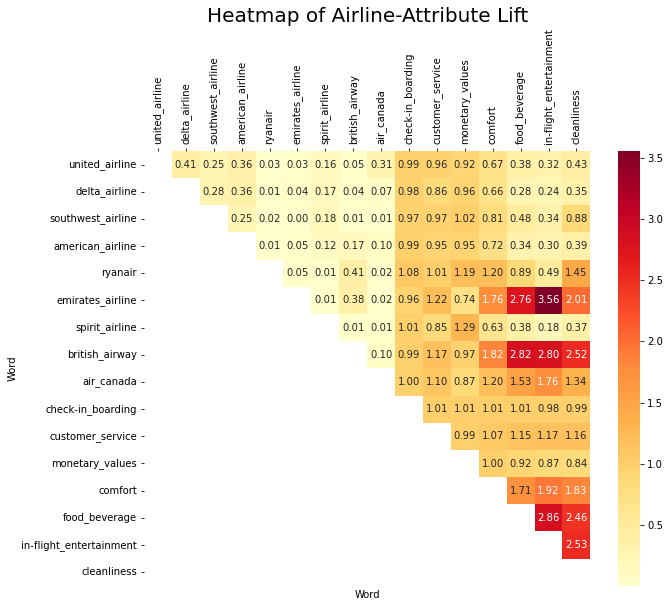

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,8))
plt.title('Heatmap of Airline-Attribute Lift', fontsize = 20)
ax.xaxis.tick_top()
sns.heatmap(airline_attr_lift_df, cmap = 'YlOrRd', annot = True, fmt='.2f')

In [72]:
airline_attr_dissimi_df = pd.DataFrame(data=airline_attr_dissimi_array, 
                                     index=airline_attri_list['Word'], columns=airline_attri_list['Word'])
airline_attr_dissimi_df

Word,united_airline,delta_airline,southwest_airline,american_airline,ryanair,emirates_airline,spirit_airline,british_airway,air_canada,check-in_boarding,customer_service,monetary_values,comfort,food_beverage,in-flight_entertainment,cleanliness
Word,,,,,,,,,,,,,,,,
united_airline,0.000,2.410,3.937,2.778,38.462,29.412,6.211,18.868,3.247,1.010,1.038,1.089,1.484,2.660,3.155,2.342
delta_airline,2.410,0.000,3.521,2.801,111.111,23.256,5.882,28.571,14.085,1.018,1.166,1.044,1.513,3.597,4.132,2.841
southwest_airline,3.937,3.521,0.000,4.032,45.455,250.000,5.435,200.000,200.000,1.026,1.031,0.981,1.236,2.092,2.967,1.133
american_airline,2.778,2.801,4.032,0.000,111.111,18.868,8.475,5.917,10.417,1.010,1.057,1.054,1.389,2.976,3.322,2.551
ryanair,38.462,111.111,45.455,111.111,0.000,21.739,111.111,2.469,52.632,0.927,0.992,0.842,0.831,1.129,2.024,0.688
emirates_airline,29.412,23.256,250.000,18.868,21.739,0.000,200.000,2.618,52.632,1.046,0.822,1.353,0.567,0.363,0.281,0.498
spirit_airline,6.211,5.882,5.435,8.475,111.111,200.000,0.000,71.429,200.000,0.988,1.171,0.775,1.580,2.604,5.525,2.674
british_airway,18.868,28.571,200.000,5.917,2.469,2.618,71.429,0.000,10.309,1.006,0.856,1.032,0.549,0.355,0.357,0.397
air_canada,3.247,14.085,200.000,10.417,52.632,52.632,200.000,10.309,0.000,0.997,0.905,1.147,0.833,0.654,0.567,0.747


<AxesSubplot:title={'center':'Heatmap of Airline-Attribute Dissimilarity'}, xlabel='Word', ylabel='Word'>

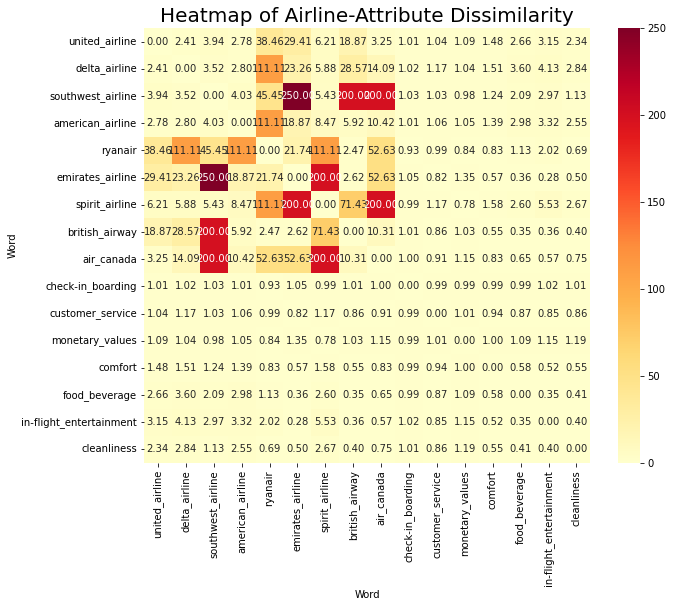

In [73]:
fig, ax = plt.subplots(figsize=(10,8))
plt.title('Heatmap of Airline-Attribute Dissimilarity', fontsize = 20)
sns.heatmap(airline_attr_dissimi_df, cmap = 'YlOrRd', annot = True, fmt='.2f')

## 4.3 Lift ratio between attributes

In [74]:
attr_lift_df = airline_attr_lift_df.iloc[9:,9:]
attr_lift_df

Word,check-in_boarding,customer_service,monetary_values,comfort,food_beverage,in-flight_entertainment,cleanliness
Word,,,,,,,
check-in_boarding,NaN,1.011,1.014,1.006,1.011,0.983,0.992
customer_service,NaN,NaN,0.990,1.070,1.153,1.169,1.163
monetary_values,NaN,NaN,NaN,1.003,0.917,0.871,0.842
comfort,NaN,NaN,NaN,NaN,1.714,1.924,1.827
food_beverage,NaN,NaN,NaN,NaN,NaN,2.860,2.457
in-flight_entertainment,NaN,NaN,NaN,NaN,NaN,NaN,2.528
cleanliness,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Heatmap of Attribute-Attribute Lift'}, xlabel='Word', ylabel='Word'>

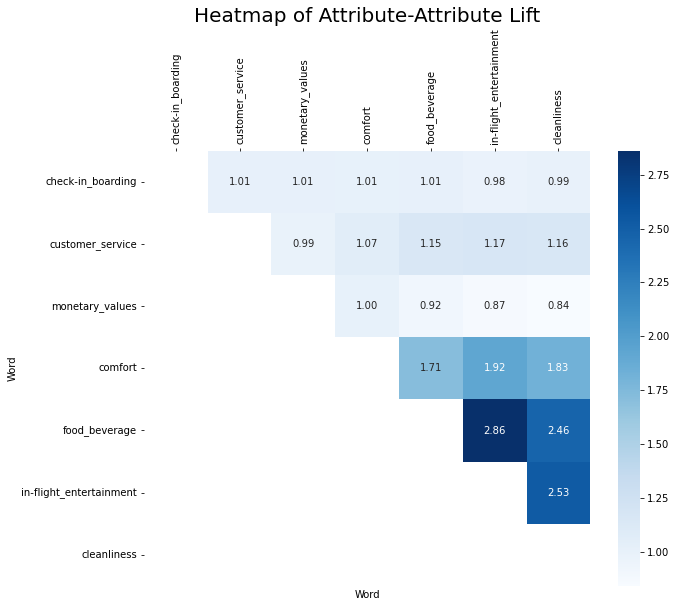

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,8))
plt.title('Heatmap of Attribute-Attribute Lift', fontsize = 20)
ax.xaxis.tick_top()
sns.heatmap(attr_lift_df, cmap = 'Blues', annot = True, fmt='.2f')

In [76]:
attr_dissimi_df = airline_attr_dissimi_df.iloc[9:,9:]
attr_dissimi_df

Word,check-in_boarding,customer_service,monetary_values,comfort,food_beverage,in-flight_entertainment,cleanliness
Word,,,,,,,
check-in_boarding,0.000,0.989,0.986,0.994,0.989,1.017,1.008
customer_service,0.989,0.000,1.010,0.935,0.867,0.855,0.860
monetary_values,0.986,1.010,0.000,0.997,1.091,1.148,1.188
comfort,0.994,0.935,0.997,0.000,0.583,0.520,0.547
food_beverage,0.989,0.867,1.091,0.583,0.000,0.350,0.407
in-flight_entertainment,1.017,0.855,1.148,0.520,0.350,0.000,0.396
cleanliness,1.008,0.860,1.188,0.547,0.407,0.396,0.000


<AxesSubplot:title={'center':'Heatmap of Attribute-Attribute Dissimilarity'}, xlabel='Word', ylabel='Word'>

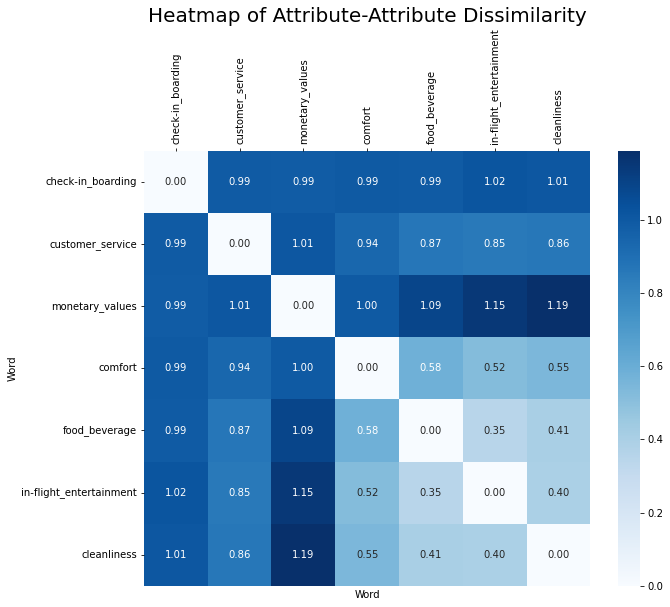

In [77]:
fig, ax = plt.subplots(figsize=(10,8))
plt.title('Heatmap of Attribute-Attribute Dissimilarity', fontsize = 20)
ax.xaxis.tick_top()
sns.heatmap(attr_dissimi_df, cmap = 'Blues', annot = True, fmt='.2f')

# 5. Visualization

## 5.1 Airline-Airline Map Visualization

In [78]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# fit our dissimilarity data frame into MDS
mds = MDS(2,random_state=0,dissimilarity='precomputed')
coordinates = mds.fit_transform(airline_dissimi_df)

# generate coordinate for plotting
coordinates_df = pd.DataFrame(data=coordinates)

Text(0.5, 1.0, 'Elbow Method for KMeans Clustering with Lift Ratio')

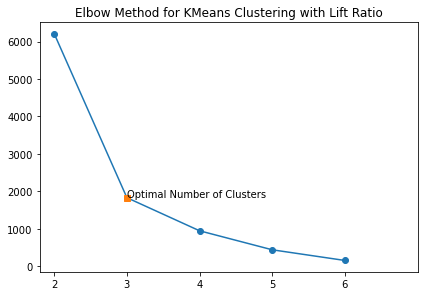

In [79]:
# we want to separate airline brands into different communities
# therefore we need to performan unsupervised learning to determine clusters

# we first need to find out the optimal number of clusters via Elbow Method
from sklearn.cluster import KMeans
withinss = []
for i in range(2,7):
    kmeans = KMeans(n_clusters = i)
    cluster = kmeans.fit(coordinates_df)
    labels = cluster.predict(coordinates_df)
    withinss.append(cluster.inertia_)

# plotting out elbow method result
import matplotlib.pyplot as plt
plt.xticks(np.arange(2, 7, 1))
plt.plot([2,3,4,5,6],withinss,'-o')
x0 = [3]
y0 = [withinss[1]]
plt.xlim([1.8, 7])
plt.plot(x0, y0, "s")
plt.annotate("Optimal Number of Clusters", (x0[0], y0[0]))
plt.tight_layout()
plt.title("Elbow Method for KMeans Clustering with Lift Ratio")

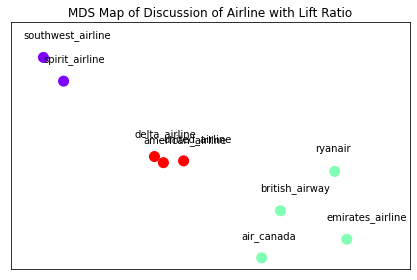

In [80]:
# The optimal number of clusters is 3
# Then we perform K Means clustering with number of clusters = 3
kmeans = KMeans(n_clusters = 3)
cluster = kmeans.fit(coordinates_df)
labels = cluster.predict(coordinates_df)
plt.scatter(coordinates_df.iloc[:,:1],coordinates_df.iloc[:,1:2],c=labels,cmap='rainbow',s=100)

# plotting out the result of clustering
for i in range(len(airline_dissimi_df.columns)):
    x = coordinates[i,0]
    y = coordinates[i,1]
    plt.annotate(airline_dissimi_df.columns[i], xy = (x, y), xytext = (-20, 20),textcoords = 'offset points')
plt.xlim([-70, 75])    
plt.ylim([-50, 70]) 

#get current axes
ax = plt.gca()

#hide x-axis
ax.get_xaxis().set_visible(False)

#hide y-axis
ax.get_yaxis().set_visible(False)

plt.title("MDS Map of Discussion of Airline with Lift Ratio")

plt.tight_layout()
plt.show()


## 5.2 Airline-Attribute Map Visualization

In [81]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# fit our dissimilarity data frame into MDS
mds = MDS(2,random_state=0,dissimilarity='precomputed')
coordinates = mds.fit_transform(airline_attr_dissimi_df)

# generate coordinate for plotting
coordinates_df = pd.DataFrame(data=coordinates)

Text(0.5, 1.0, 'Elbow Method for KMeans Clustering with Lift Ratio')

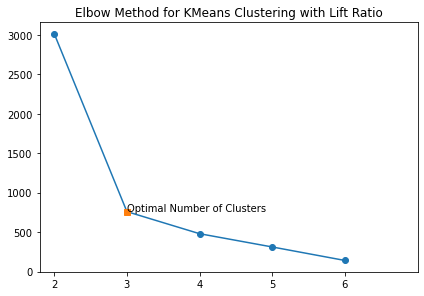

In [82]:
# we want to separate airline attributes into different communities
# therefore we need to performan unsupervised learning to determine clusters

# we first need to find out the optimal number of clusters via Elbow Method
from sklearn.cluster import KMeans
withinss = []
for i in range(2,7):
    kmeans = KMeans(n_clusters = i)
    cluster = kmeans.fit(coordinates_df)
    labels = cluster.predict(coordinates_df)
    withinss.append(cluster.inertia_)

# plotting out elbow method result
import matplotlib.pyplot as plt
plt.xticks(np.arange(2, 7, 1))
plt.plot([2,3,4,5,6],withinss,'-o')
x0 = [3]
y0 = [withinss[1]]
plt.xlim([1.8, 7])
plt.plot(x0, y0, "s")
plt.annotate("Optimal Number of Clusters", (x0[0], y0[0]))
plt.tight_layout()
plt.title("Elbow Method for KMeans Clustering with Lift Ratio")

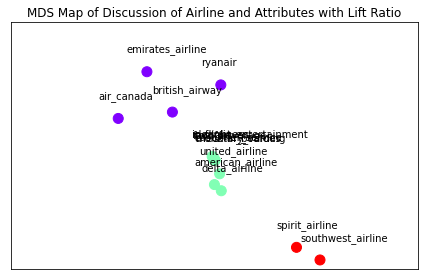

In [83]:
# The optimal number of clusters is 3
# Then we perform K Means clustering with number of clusters = 3
kmeans = KMeans(n_clusters = 3)
cluster = kmeans.fit(coordinates_df)
labels = cluster.predict(coordinates_df)
plt.scatter(coordinates_df.iloc[:,:1],coordinates_df.iloc[:,1:2],c=labels,cmap='rainbow',s=100)

# plotting out the result of clustering
for i in range(len(airline_attr_dissimi_df.columns)):
    x = coordinates[i,0]
    y = coordinates[i,1]
    plt.annotate(airline_attr_dissimi_df.columns[i], xy = (x, y), xytext = (-20, 20),textcoords = 'offset points')
plt.xlim([-50, 50])    
plt.ylim([-40, 50]) 

#get current axes
ax = plt.gca()

#hide x-axis
ax.get_xaxis().set_visible(False)

#hide y-axis
ax.get_yaxis().set_visible(False)

plt.title("MDS Map of Discussion of Airline and Attributes with Lift Ratio")

plt.tight_layout()
plt.show()


## 5.3 Airline-Attribute Map Visualization

In [84]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# fit our dissimilarity data frame into MDS
mds = MDS(2,random_state=0,dissimilarity='precomputed')
coordinates = mds.fit_transform(attr_dissimi_df)

# generate coordinate for plotting
coordinates_df = pd.DataFrame(data=coordinates)

Text(0.5, 1.0, 'Elbow Method for KMeans Clustering with Lift Ratio')

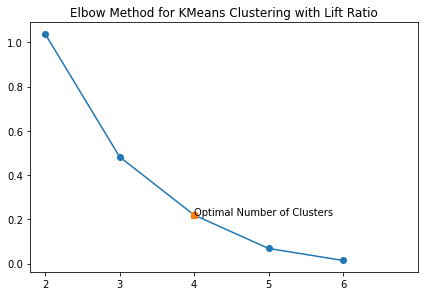

In [85]:
# we want to separate airline attributes into different communities
# therefore we need to performan unsupervised learning to determine clusters

# we first need to find out the optimal number of clusters via Elbow Method
from sklearn.cluster import KMeans
withinss = []
for i in range(2,7):
    kmeans = KMeans(n_clusters = i)
    cluster = kmeans.fit(coordinates_df)
    labels = cluster.predict(coordinates_df)
    withinss.append(cluster.inertia_)

# plotting out elbow method result
import matplotlib.pyplot as plt
plt.xticks(np.arange(2, 7, 1))
plt.plot([2,3,4,5,6],withinss,'-o')
x0 = [4]
y0 = [withinss[2]]
plt.xlim([1.8, 7])
plt.plot(x0, y0, "s")
plt.annotate("Optimal Number of Clusters", (x0[0], y0[0]))
plt.tight_layout()
plt.title("Elbow Method for KMeans Clustering with Lift Ratio")

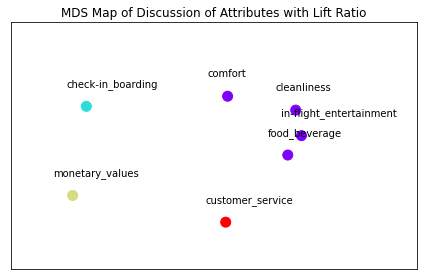

In [86]:
# The optimal number of clusters is 4
# Then we perform K Means clustering with number of clusters = 3
kmeans = KMeans(n_clusters = 4)
cluster = kmeans.fit(coordinates_df)
labels = cluster.predict(coordinates_df)
plt.scatter(coordinates_df.iloc[:,:1],coordinates_df.iloc[:,1:2],c=labels,cmap='rainbow',s=100)

# plotting out the result of clustering
for i in range(len(attr_dissimi_df.columns)):
    x = coordinates[i,0]
    y = coordinates[i,1]
    plt.annotate(attr_dissimi_df.columns[i], xy = (x, y), xytext = (-20, 20),textcoords = 'offset points')
plt.xlim([-1, 1])    
plt.ylim([-1, 1]) 

#get current axes
ax = plt.gca()

#hide x-axis
ax.get_xaxis().set_visible(False)

#hide y-axis
ax.get_yaxis().set_visible(False)

plt.title("MDS Map of Discussion of Attributes with Lift Ratio")

plt.tight_layout()
plt.show()


## 5.4 Wordcloud

In [87]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

There are 13539662 words in the combination of all review.


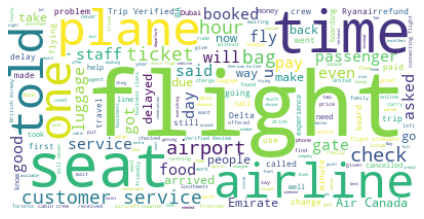

In [88]:
# wordcloud from All reviews
text = " ".join(review for review in review.Review)
print ("There are {} words in the combination of all review.".format(len(text)))
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["car", "preference", "attribute", "brand"])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.show()

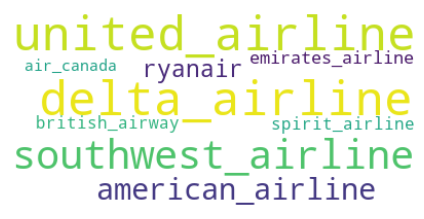

In [89]:
# Airline wordcloud

d = {}
for a, x in airline_count_df.values:
    d[a] = x

import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white")
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.show()

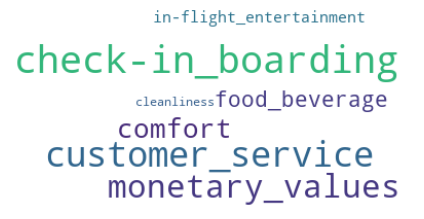

In [90]:
# Attributes wordcloud

d = {}
for a, x in attr_count_df.values:
    d[a] = x

import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white")
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.show()

## 5.4 Airlinewise Attribute Plotting

In [91]:
import pandas as pd
df = pd.read_csv('df_airline_attri_final.csv')
df = df.iloc[:,1:]
df

,Airline_Mentioned,Attribute_Mentioned
0,['delta_airline'],['comfort']
1,['delta_airline'],"['check-in_boarding', 'customer_service', 'mon..."
2,['delta_airline'],['check-in_boarding']
3,['delta_airline'],"['check-in_boarding', 'monetary_values']"
4,['delta_airline'],"['comfort', 'check-in_boarding', 'monetary_val..."
...,...,...
19777,['british_airway'],"['check-in_boarding', 'customer_service', 'com..."
19778,['british_airway'],['customer_service']
19779,['british_airway'],"['comfort', 'cleanliness', 'customer_service',..."
19780,['british_airway'],['customer_service']


In [92]:
for i in range(len(df['Airline_Mentioned'])):
    df['Airline_Mentioned'][i] = df['Airline_Mentioned'][i][1:]
    df['Airline_Mentioned'][i] = df['Airline_Mentioned'][i][:-1]
for i in range(len(df['Attribute_Mentioned'])):
    df['Attribute_Mentioned'][i] = df['Attribute_Mentioned'][i][1:]
    df['Attribute_Mentioned'][i] = df['Attribute_Mentioned'][i][:-1]

In [93]:
# first generate dataframes for each Airline
united_airline = df[df['Airline_Mentioned'].str.contains('united_airline')]
delta_airline = df[df['Airline_Mentioned'].str.contains('delta_airline')]
southwest_airline = df[df['Airline_Mentioned'].str.contains('southwest_airline')]
american_airline = df[df['Airline_Mentioned'].str.contains('american_airline')]
ryanair = df[df['Airline_Mentioned'].str.contains('ryanair')]
emirates_airline = df[df['Airline_Mentioned'].str.contains('emirates_airline')]
spirit_airline = df[df['Airline_Mentioned'].str.contains('spirit_airline')]
british_airway = df[df['Airline_Mentioned'].str.contains('british_airway')]
air_canada = df[df['Airline_Mentioned'].str.contains('air_canada')]
frontier_airline = df[df['Airline_Mentioned'].str.contains('frontier_airline')]

### 5.4.1 United Airlines

In [94]:
# create united dataframe for bar plot
attributes = pd.DataFrame(["comfort","in-flight_entertainment","customer_service","monetary_values","cleanliness","check-in_boarding","food_beverage"],columns=['attributes'])
united_comfort = len(united_airline[united_airline['Attribute_Mentioned'].str.contains('comfort')]['Attribute_Mentioned'])
united_in_flight_entertainment = len(united_airline[united_airline['Attribute_Mentioned'].str.contains('in-flight_entertainment')]['Attribute_Mentioned'])
united_customer_service = len(united_airline[united_airline['Attribute_Mentioned'].str.contains('customer_service')]['Attribute_Mentioned'])
united_monetary_values = len(united_airline[united_airline['Attribute_Mentioned'].str.contains('monetary_values')]['Attribute_Mentioned'])
united_cleanliness = len(united_airline[united_airline['Attribute_Mentioned'].str.contains('cleanliness')]['Attribute_Mentioned'])
united_check_in_boardin = len(united_airline[united_airline['Attribute_Mentioned'].str.contains('check-in_boarding')]['Attribute_Mentioned'])
united_food_beverage = len(united_airline[united_airline['Attribute_Mentioned'].str.contains('food_beverage')]['Attribute_Mentioned'])
united_attri_count = pd.DataFrame([united_comfort, united_in_flight_entertainment, united_customer_service, united_monetary_values, united_cleanliness, united_check_in_boardin, united_food_beverage],columns=['counts'])
united_attri = pd.concat([attributes,united_attri_count],axis=1)
united_attri = united_attri.sort_values(by=['counts'], ascending=False)
united_attri['counts']=united_attri['counts'].fillna(0)

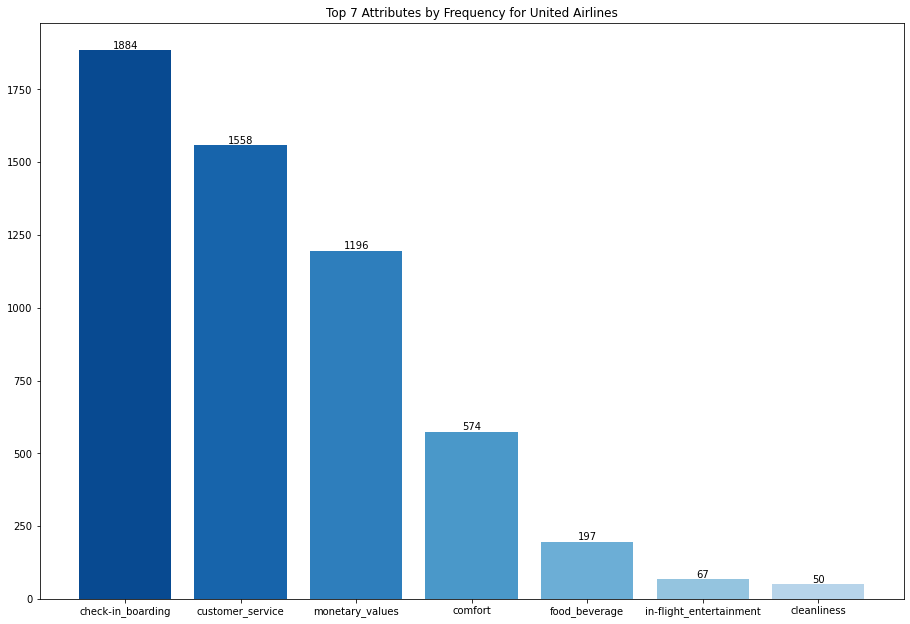

In [95]:
# bar plot of top 7 attributes for united

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()    # initiate a figure
ax = fig.add_axes([1,1,2,2])    #  set up plot size and axes
k = ax.bar(united_attri['attributes'],united_attri['counts'],color = sns.color_palette('Blues_r',9))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Top 7 Attributes by Frequency for United Airlines')
plt.show()

### 5.4.2 Delta Airlines

In [96]:
# create american airline dataframe for bar plot
attributes = pd.DataFrame(["comfort","in-flight_entertainment","customer_service","monetary_values","cleanliness","check-in_boarding","food_beverage"],columns=['attributes'])
delta_comfort = len(delta_airline[delta_airline['Attribute_Mentioned'].str.contains('comfort')]['Attribute_Mentioned'])
delta_in_flight_entertainment = len(delta_airline[delta_airline['Attribute_Mentioned'].str.contains('in-flight_entertainment')]['Attribute_Mentioned'])
delta_customer_service = len(delta_airline[delta_airline['Attribute_Mentioned'].str.contains('customer_service')]['Attribute_Mentioned'])
delta_monetary_values = len(delta_airline[delta_airline['Attribute_Mentioned'].str.contains('monetary_values')]['Attribute_Mentioned'])
delta_cleanliness = len(delta_airline[delta_airline['Attribute_Mentioned'].str.contains('cleanliness')]['Attribute_Mentioned'])
delta_check_in_boardin = len(delta_airline[delta_airline['Attribute_Mentioned'].str.contains('check-in_boarding')]['Attribute_Mentioned'])
delta_food_beverage = len(delta_airline[delta_airline['Attribute_Mentioned'].str.contains('food_beverage')]['Attribute_Mentioned'])
delta_attri_count = pd.DataFrame([delta_comfort, delta_in_flight_entertainment, delta_customer_service, delta_monetary_values, delta_cleanliness, delta_check_in_boardin, delta_food_beverage],columns=['counts'])
delta_attri = pd.concat([attributes,delta_attri_count],axis=1)
delta_attri = delta_attri.sort_values(by=['counts'], ascending=False)
delta_attri['counts']=delta_attri['counts'].fillna(0)

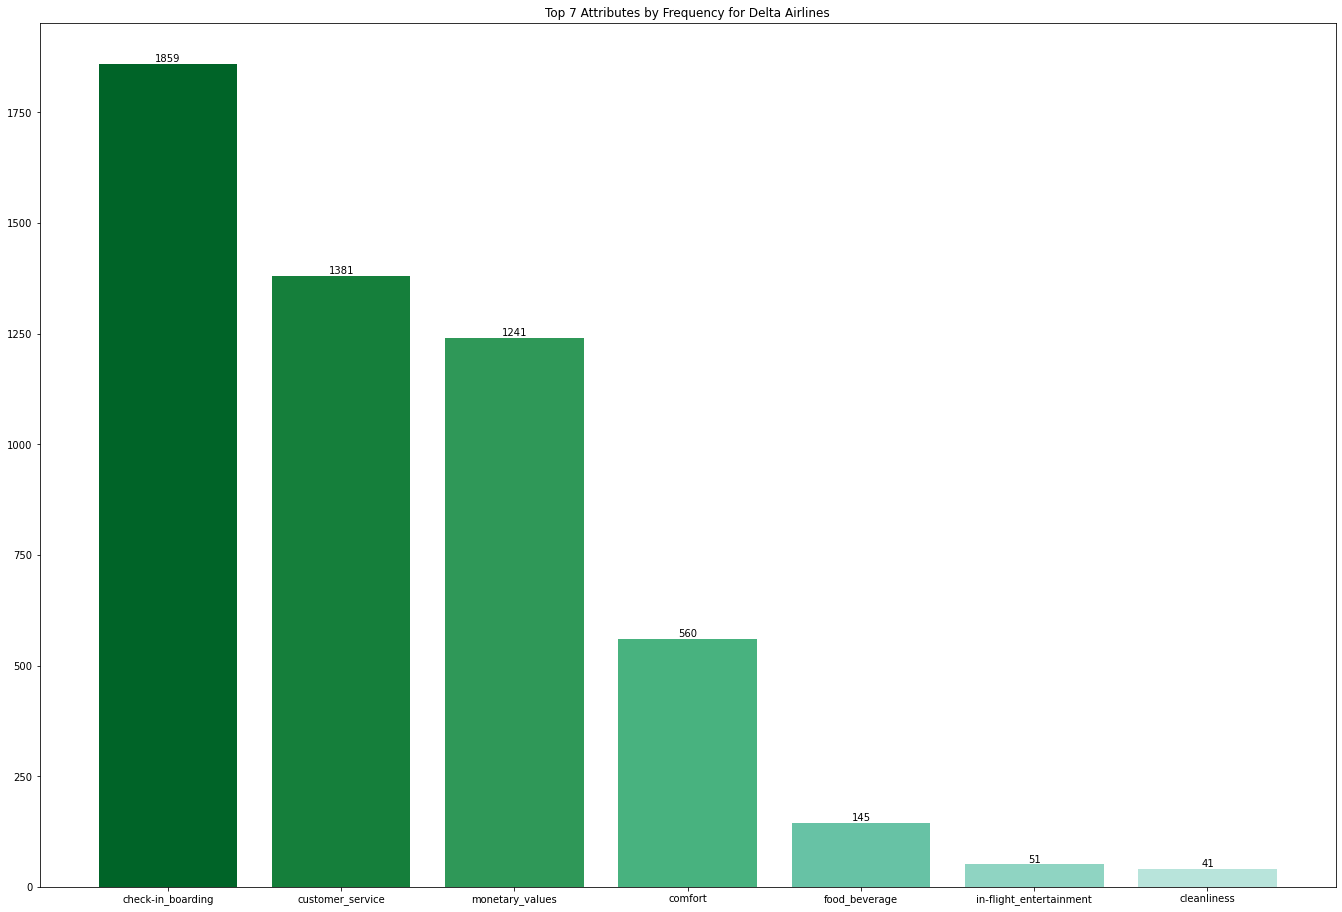

In [97]:
# bar plot of top 7 attributes for united

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()    # initiate a figure
ax = fig.add_axes([2,2,3,3])    #  set up plot size and axes
k = ax.bar(delta_attri['attributes'],delta_attri['counts'],color = sns.color_palette('BuGn_r',9))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Top 7 Attributes by Frequency for Delta Airlines')
plt.show()

### 5.4.3 Southwest Airlines

In [98]:
# create american airline dataframe for bar plot
attributes = pd.DataFrame(["comfort","in-flight_entertainment","customer_service","monetary_values","cleanliness","check-in_boarding","food_beverage"],columns=['attributes'])
southwest_comfort = len(southwest_airline[southwest_airline['Attribute_Mentioned'].str.contains('comfort')]['Attribute_Mentioned'])
southwest_in_flight_entertainment = len(southwest_airline[southwest_airline['Attribute_Mentioned'].str.contains('in-flight_entertainment')]['Attribute_Mentioned'])
southwest_customer_service = len(southwest_airline[southwest_airline['Attribute_Mentioned'].str.contains('customer_service')]['Attribute_Mentioned'])
southwest_monetary_values = len(southwest_airline[southwest_airline['Attribute_Mentioned'].str.contains('monetary_values')]['Attribute_Mentioned'])
southwest_cleanliness = len(southwest_airline[southwest_airline['Attribute_Mentioned'].str.contains('cleanliness')]['Attribute_Mentioned'])
southwest_check_in_boardin = len(southwest_airline[southwest_airline['Attribute_Mentioned'].str.contains('check-in_boarding')]['Attribute_Mentioned'])
southwest_food_beverage = len(southwest_airline[southwest_airline['Attribute_Mentioned'].str.contains('food_beverage')]['Attribute_Mentioned'])
southwest_attri_count = pd.DataFrame([southwest_comfort, southwest_in_flight_entertainment, southwest_customer_service, southwest_monetary_values, southwest_cleanliness, southwest_check_in_boardin, southwest_food_beverage],columns=['counts'])
southwest_attri = pd.concat([attributes,southwest_attri_count],axis=1)
southwest_attri = southwest_attri.sort_values(by=['counts'], ascending=False)
southwest_attri['counts']=southwest_attri['counts'].fillna(0)

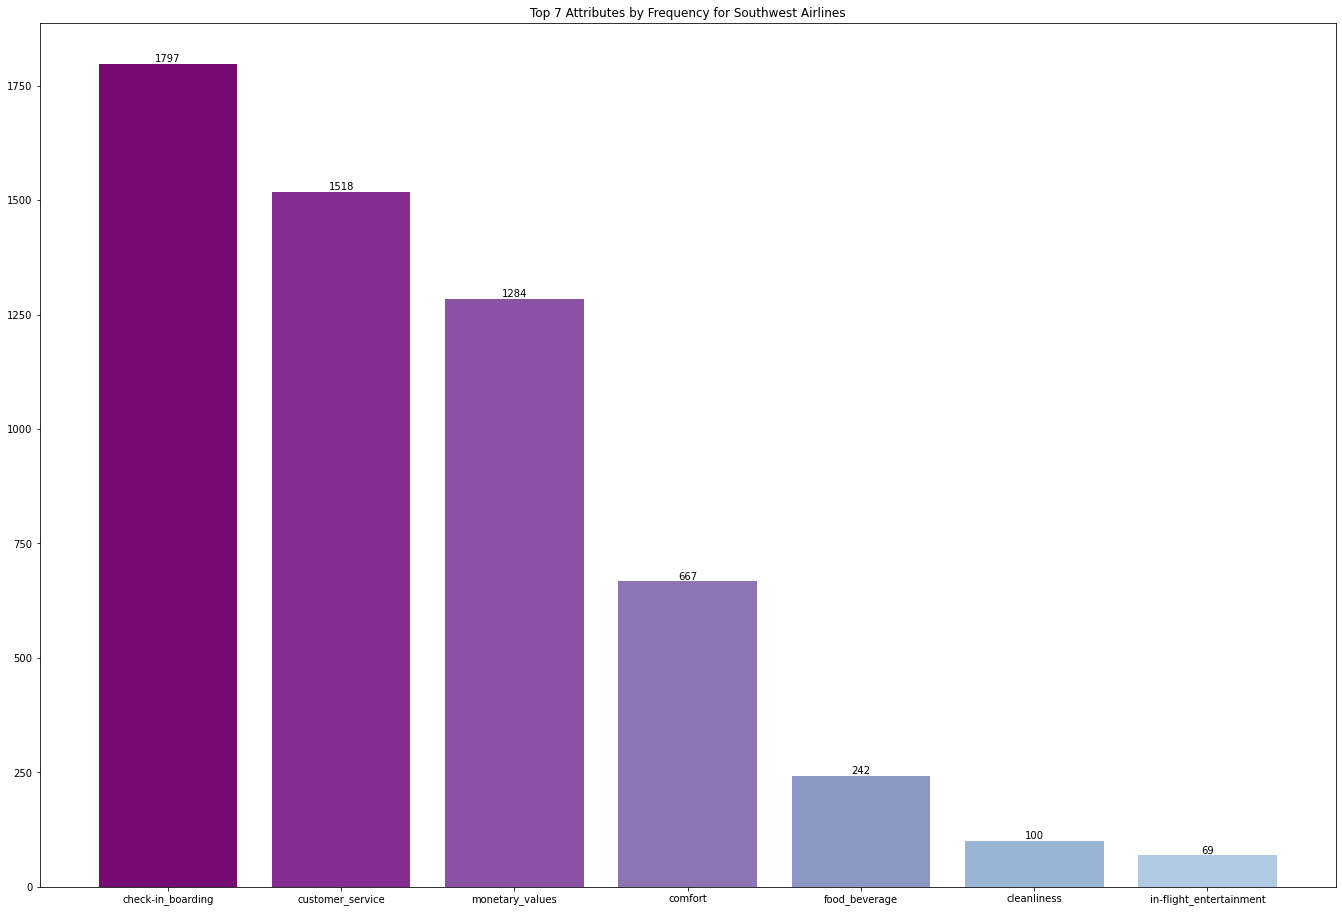

In [99]:
# bar plot of top 7 attributes for united

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()    # initiate a figure
ax = fig.add_axes([2,2,3,3])    #  set up plot size and axes
k = ax.bar(southwest_attri['attributes'],southwest_attri['counts'],color = sns.color_palette('BuPu_r',9))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Top 7 Attributes by Frequency for Southwest Airlines')
plt.show()

### 5.4.4 American Airlines

In [100]:
# create american airline dataframe for bar plot
attributes = pd.DataFrame(["comfort","in-flight_entertainment","customer_service","monetary_values","cleanliness","check-in_boarding","food_beverage"],columns=['attributes'])
american_comfort = len(american_airline[american_airline['Attribute_Mentioned'].str.contains('comfort')]['Attribute_Mentioned'])
american_in_flight_entertainment = len(american_airline[american_airline['Attribute_Mentioned'].str.contains('in-flight_entertainment')]['Attribute_Mentioned'])
american_customer_service = len(american_airline[american_airline['Attribute_Mentioned'].str.contains('customer_service')]['Attribute_Mentioned'])
american_monetary_values = len(american_airline[american_airline['Attribute_Mentioned'].str.contains('monetary_values')]['Attribute_Mentioned'])
american_cleanliness = len(american_airline[american_airline['Attribute_Mentioned'].str.contains('cleanliness')]['Attribute_Mentioned'])
american_check_in_boardin = len(american_airline[american_airline['Attribute_Mentioned'].str.contains('check-in_boarding')]['Attribute_Mentioned'])
american_food_beverage = len(american_airline[american_airline['Attribute_Mentioned'].str.contains('food_beverage')]['Attribute_Mentioned'])
american_attri_count = pd.DataFrame([american_comfort, american_in_flight_entertainment, american_customer_service, american_monetary_values, american_cleanliness, american_check_in_boardin, american_food_beverage],columns=['counts'])
american_attri = pd.concat([attributes,american_attri_count],axis=1)
american_attri = american_attri.sort_values(by=['counts'], ascending=False)
american_attri['counts']=american_attri['counts'].fillna(0)

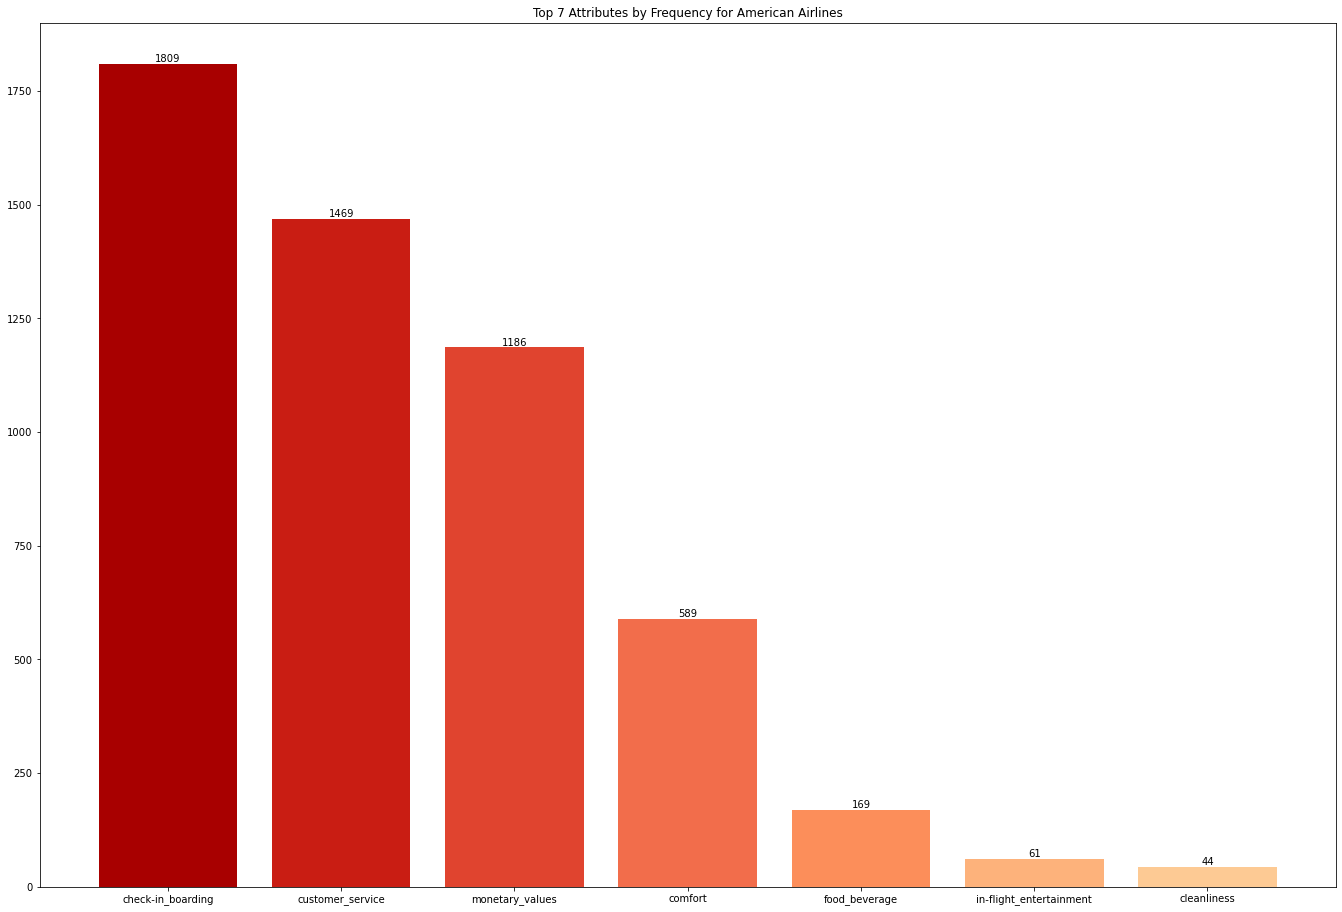

In [101]:
# bar plot of top 7 attributes for united

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()    # initiate a figure
ax = fig.add_axes([2,2,3,3])    #  set up plot size and axes
k = ax.bar(american_attri['attributes'],american_attri['counts'],color = sns.color_palette('OrRd_r',9))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Top 7 Attributes by Frequency for American Airlines')
plt.show()

### 5.4.5 Ryanair

In [102]:
# create ryanair dataframe for bar plot
attributes = pd.DataFrame(["comfort","in-flight_entertainment","customer_service","monetary_values","cleanliness","check-in_boarding","food_beverage"],columns=['attributes'])
ryanair_comfort = len(ryanair[ryanair['Attribute_Mentioned'].str.contains('comfort')]['Attribute_Mentioned'])
ryanair_in_flight_entertainment = len(ryanair[ryanair['Attribute_Mentioned'].str.contains('in-flight_entertainment')]['Attribute_Mentioned'])
ryanair_customer_service = len(ryanair[ryanair['Attribute_Mentioned'].str.contains('customer_service')]['Attribute_Mentioned'])
ryanair_monetary_values = len(ryanair[ryanair['Attribute_Mentioned'].str.contains('monetary_values')]['Attribute_Mentioned'])
ryanair_cleanliness = len(ryanair[ryanair['Attribute_Mentioned'].str.contains('cleanliness')]['Attribute_Mentioned'])
ryanair_check_in_boardin = len(ryanair[ryanair['Attribute_Mentioned'].str.contains('check-in_boarding')]['Attribute_Mentioned'])
ryanair_food_beverage = len(ryanair[ryanair['Attribute_Mentioned'].str.contains('food_beverage')]['Attribute_Mentioned'])
ryanair_attri_count = pd.DataFrame([ryanair_comfort, ryanair_in_flight_entertainment, ryanair_customer_service, ryanair_monetary_values, ryanair_cleanliness, ryanair_check_in_boardin, ryanair_food_beverage],columns=['counts'])
ryanair_attri = pd.concat([attributes,ryanair_attri_count],axis=1)
ryanair_attri = ryanair_attri.sort_values(by=['counts'], ascending=False)
ryanair_attri['counts']=ryanair_attri['counts'].fillna(0)

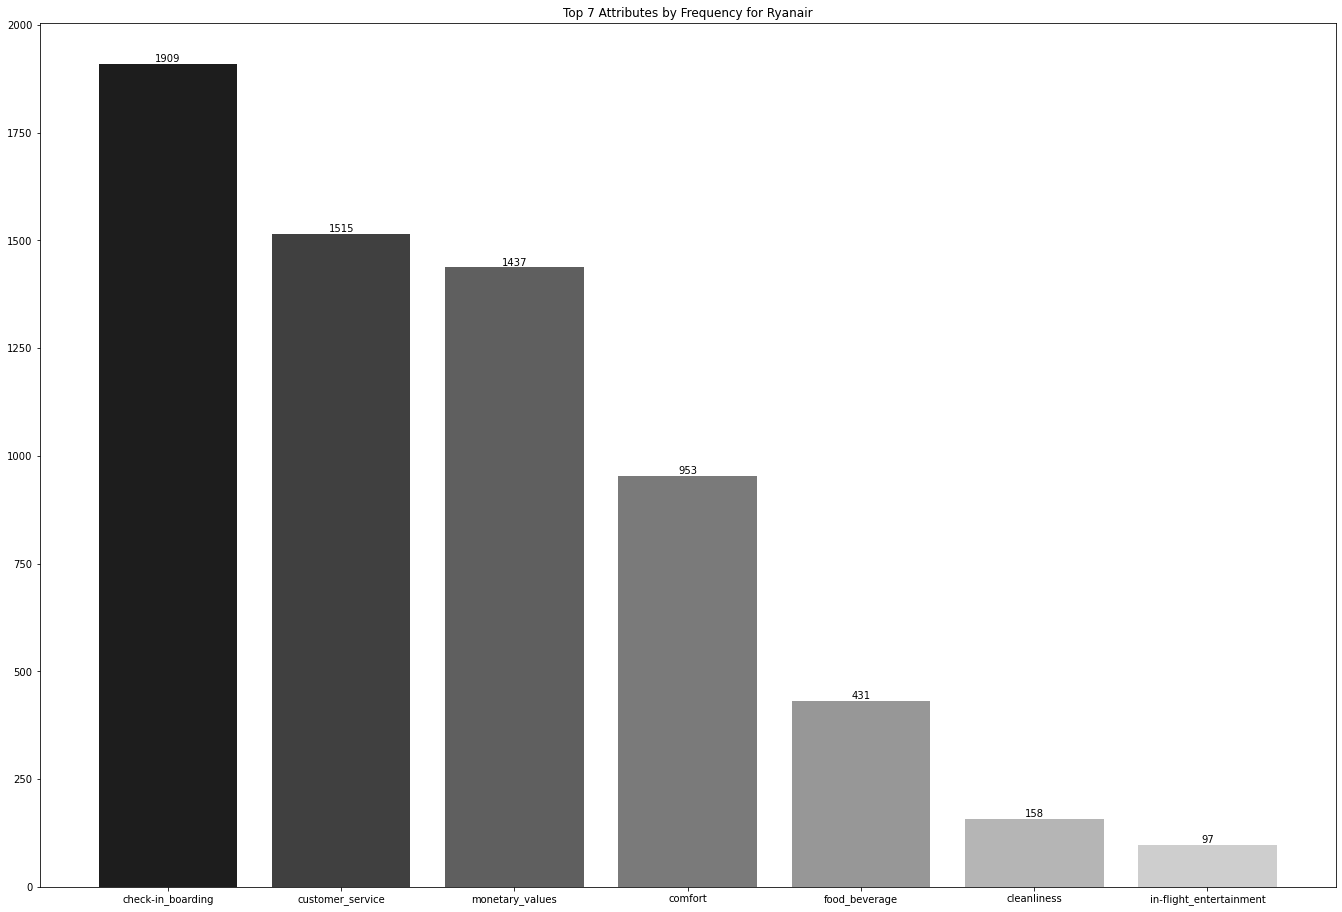

In [103]:
# bar plot of top 7 attributes for ryanair

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()    # initiate a figure
ax = fig.add_axes([2,2,3,3])    #  set up plot size and axes
k = ax.bar(ryanair_attri['attributes'],ryanair_attri['counts'],color = sns.color_palette('Greys_r',9))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Top 7 Attributes by Frequency for Ryanair')
plt.show()

### 5.4.6 Emirates Airlines

In [104]:
# create emirates dataframe for bar plot
attributes = pd.DataFrame(["comfort","in-flight_entertainment","customer_service","monetary_values","cleanliness","check-in_boarding","food_beverage"],columns=['attributes'])
emirates_comfort = len(emirates_airline[emirates_airline['Attribute_Mentioned'].str.contains('comfort')]['Attribute_Mentioned'])
emirates_in_flight_entertainment = len(emirates_airline[emirates_airline['Attribute_Mentioned'].str.contains('in-flight_entertainment')]['Attribute_Mentioned'])
emirates_customer_service = len(emirates_airline[emirates_airline['Attribute_Mentioned'].str.contains('customer_service')]['Attribute_Mentioned'])
emirates_monetary_values = len(emirates_airline[emirates_airline['Attribute_Mentioned'].str.contains('monetary_values')]['Attribute_Mentioned'])
emirates_cleanliness = len(emirates_airline[emirates_airline['Attribute_Mentioned'].str.contains('cleanliness')]['Attribute_Mentioned'])
emirates_check_in_boardin = len(emirates_airline[emirates_airline['Attribute_Mentioned'].str.contains('check-in_boarding')]['Attribute_Mentioned'])
emirates_food_beverage = len(emirates_airline[emirates_airline['Attribute_Mentioned'].str.contains('food_beverage')]['Attribute_Mentioned'])
emirates_attri_count = pd.DataFrame([emirates_comfort, emirates_in_flight_entertainment, emirates_customer_service, emirates_monetary_values, emirates_cleanliness, emirates_check_in_boardin, emirates_food_beverage],columns=['counts'])
emirates_attri = pd.concat([attributes,emirates_attri_count],axis=1)
emirates_attri = emirates_attri.sort_values(by=['counts'],ascending=False)
emirates_attri['counts']=emirates_attri['counts'].fillna(0)

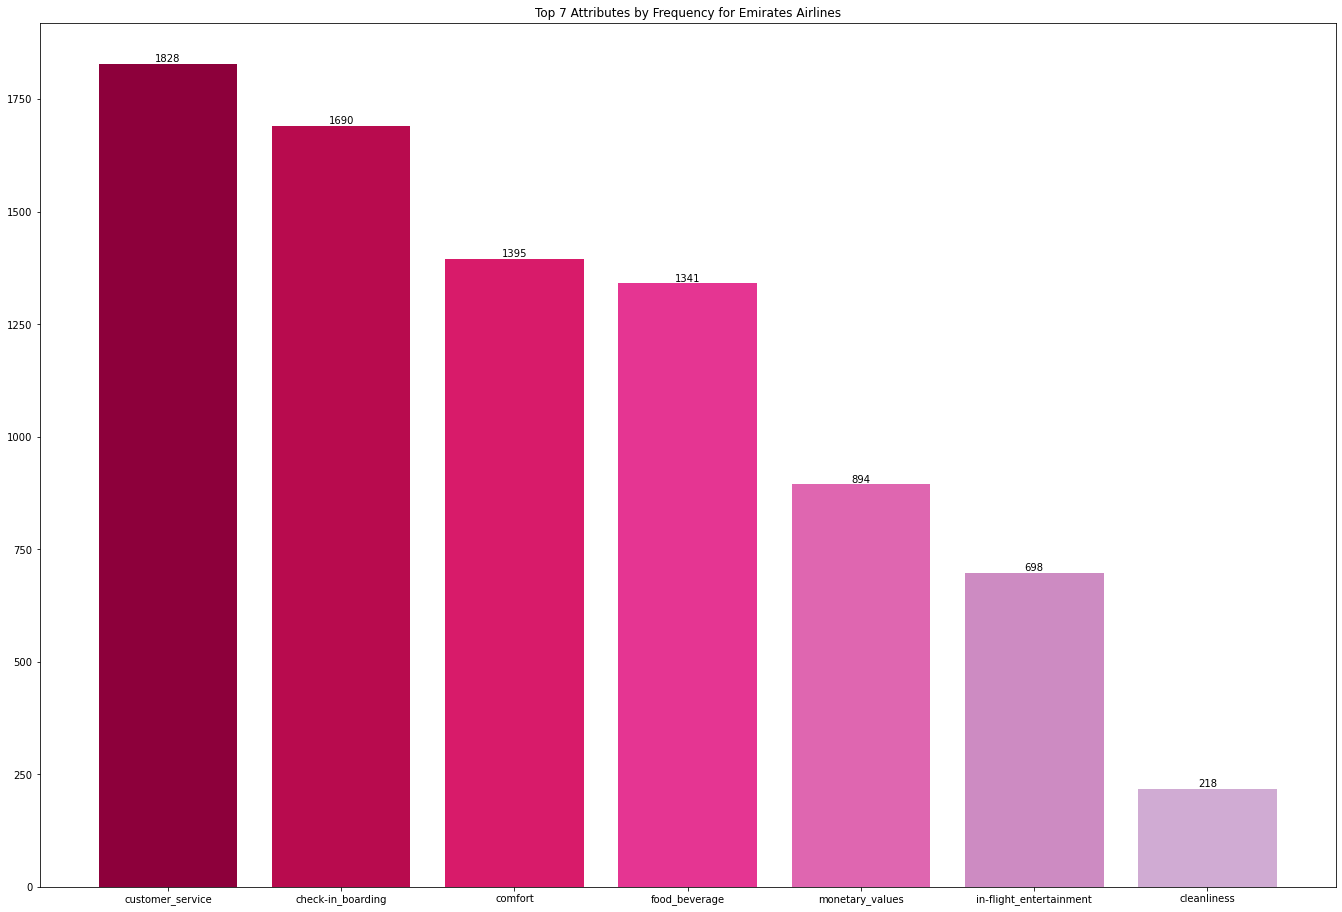

In [105]:
# bar plot of top 7 attributes for emirates

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()    # initiate a figure
ax = fig.add_axes([2,2,3,3])    #  set up plot size and axes
k = ax.bar(emirates_attri['attributes'],emirates_attri['counts'],color = sns.color_palette('PuRd_r',9))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Top 7 Attributes by Frequency for Emirates Airlines')
plt.show()

### 5.4.7 Spirit Airlines

In [106]:
# create spirit dataframe for bar plot
attributes = pd.DataFrame(["comfort","in-flight_entertainment","customer_service","monetary_values","cleanliness","check-in_boarding","food_beverage"],columns=['attributes'])
spirit_comfort = len(spirit_airline[spirit_airline['Attribute_Mentioned'].str.contains('comfort')]['Attribute_Mentioned'])
spirit_in_flight_entertainment = len(spirit_airline[spirit_airline['Attribute_Mentioned'].str.contains('in-flight_entertainment')]['Attribute_Mentioned'])
spirit_customer_service = len(spirit_airline[spirit_airline['Attribute_Mentioned'].str.contains('customer_service')]['Attribute_Mentioned'])
spirit_monetary_values = len(spirit_airline[spirit_airline['Attribute_Mentioned'].str.contains('monetary_values')]['Attribute_Mentioned'])
spirit_cleanliness = len(spirit_airline[spirit_airline['Attribute_Mentioned'].str.contains('cleanliness')]['Attribute_Mentioned'])
spirit_check_in_boardin = len(spirit_airline[spirit_airline['Attribute_Mentioned'].str.contains('check-in_boarding')]['Attribute_Mentioned'])
spirit_food_beverage = len(spirit_airline[spirit_airline['Attribute_Mentioned'].str.contains('food_beverage')]['Attribute_Mentioned'])
spirit_attri_count = pd.DataFrame([spirit_comfort, spirit_in_flight_entertainment, spirit_customer_service, spirit_monetary_values, spirit_cleanliness, spirit_check_in_boardin, spirit_food_beverage],columns=['counts'])
spirit_attri = pd.concat([attributes,spirit_attri_count],axis=1)
spirit_attri = spirit_attri.sort_values(by=['counts'],ascending=False)
spirit_attri['counts']=spirit_attri['counts'].fillna(0)

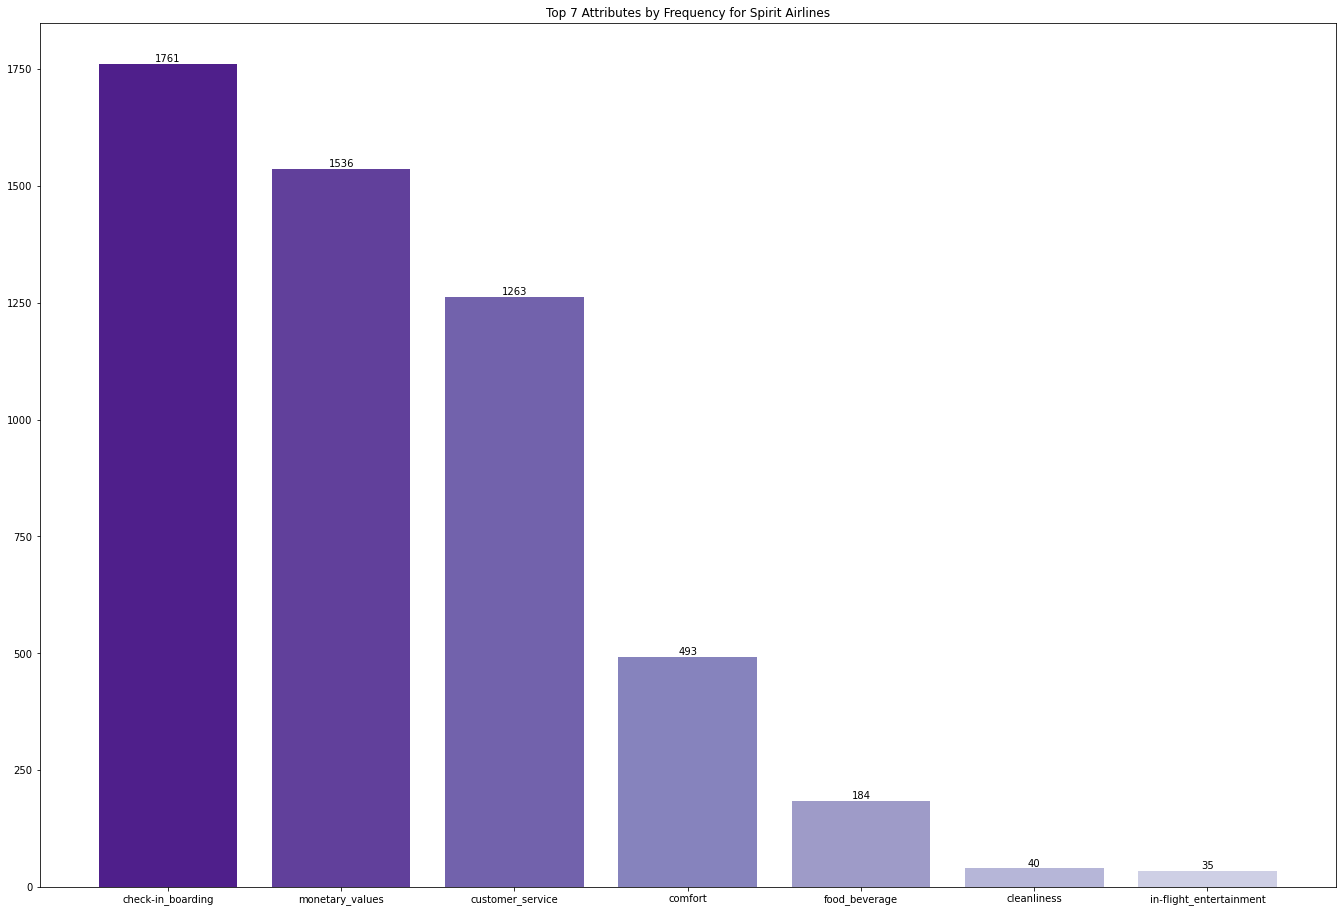

In [107]:
# bar plot of top 7 attributes for spirit

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()    # initiate a figure
ax = fig.add_axes([2,2,3,3])    #  set up plot size and axes
k = ax.bar(spirit_attri['attributes'],spirit_attri['counts'],color = sns.color_palette('Purples_r',9))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Top 7 Attributes by Frequency for Spirit Airlines')
plt.show()

### 5.4.8 British Airways

In [108]:
# create british_airway dataframe for bar plot
attributes = pd.DataFrame(["comfort","in-flight_entertainment","customer_service","monetary_values","cleanliness","check-in_boarding","food_beverage"],columns=['attributes'])
british_airway_comfort = len(british_airway[british_airway['Attribute_Mentioned'].str.contains('comfort')]['Attribute_Mentioned'])
british_airway_in_flight_entertainment = len(british_airway[british_airway['Attribute_Mentioned'].str.contains('in-flight_entertainment')]['Attribute_Mentioned'])
british_airway_customer_service = len(british_airway[british_airway['Attribute_Mentioned'].str.contains('customer_service')]['Attribute_Mentioned'])
british_airway_monetary_values = len(british_airway[british_airway['Attribute_Mentioned'].str.contains('monetary_values')]['Attribute_Mentioned'])
british_airway_cleanliness = len(british_airway[british_airway['Attribute_Mentioned'].str.contains('cleanliness')]['Attribute_Mentioned'])
british_airway_check_in_boardin = len(british_airway[british_airway['Attribute_Mentioned'].str.contains('check-in_boarding')]['Attribute_Mentioned'])
british_airway_food_beverage = len(british_airway[british_airway['Attribute_Mentioned'].str.contains('food_beverage')]['Attribute_Mentioned'])
british_airway_attri_count = pd.DataFrame([british_airway_comfort, british_airway_in_flight_entertainment, british_airway_customer_service, british_airway_monetary_values, british_airway_cleanliness, british_airway_check_in_boardin, british_airway_food_beverage],columns=['counts'])
british_airway_attri = pd.concat([attributes,british_airway_attri_count],axis=1)
british_airway_attri = british_airway_attri.sort_values(by=['counts'],ascending=False)
british_airway_attri['counts']=british_airway_attri['counts'].fillna(0)

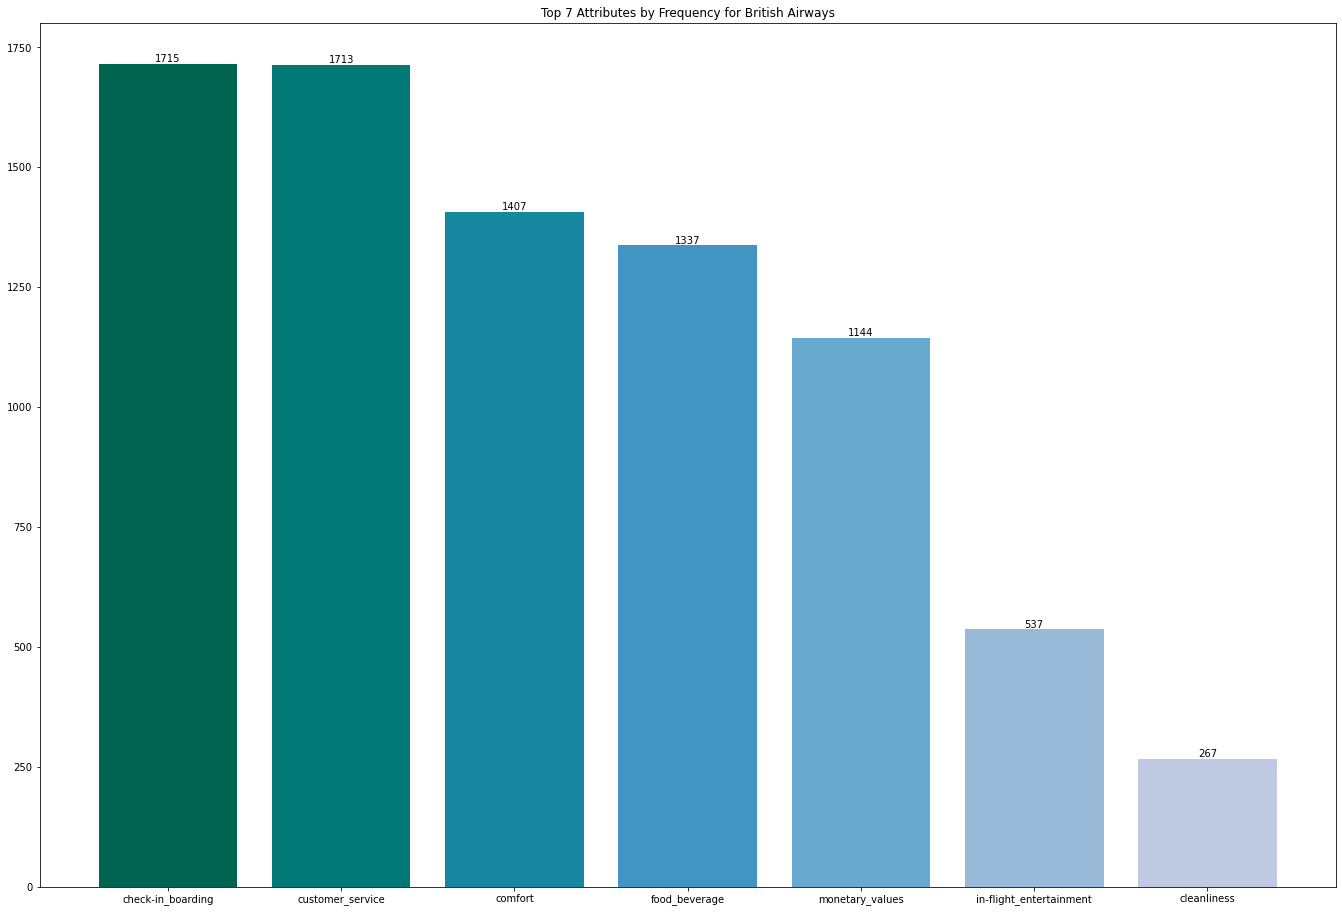

In [109]:
# bar plot of top 7 attributes for british_airway

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()    # initiate a figure
ax = fig.add_axes([2,2,3,3])    #  set up plot size and axes
k = ax.bar(british_airway_attri['attributes'],british_airway_attri['counts'],color = sns.color_palette('PuBuGn_r',9))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Top 7 Attributes by Frequency for British Airways')
plt.show()

### 5.4.9 Air Canada

In [110]:
# create air_canada dataframe for bar plot
attributes = pd.DataFrame(["comfort","in-flight_entertainment","customer_service","monetary_values","cleanliness","check-in_boarding","food_beverage"],columns=['attributes'])
air_canada_comfort = len(air_canada[air_canada['Attribute_Mentioned'].str.contains('comfort')]['Attribute_Mentioned'])
air_canada_in_flight_entertainment = len(air_canada[air_canada['Attribute_Mentioned'].str.contains('in-flight_entertainment')]['Attribute_Mentioned'])
air_canada_customer_service = len(air_canada[air_canada['Attribute_Mentioned'].str.contains('customer_service')]['Attribute_Mentioned'])
air_canada_monetary_values = len(air_canada[air_canada['Attribute_Mentioned'].str.contains('monetary_values')]['Attribute_Mentioned'])
air_canada_cleanliness = len(air_canada[air_canada['Attribute_Mentioned'].str.contains('cleanliness')]['Attribute_Mentioned'])
air_canada_check_in_boardin = len(air_canada[air_canada['Attribute_Mentioned'].str.contains('check-in_boarding')]['Attribute_Mentioned'])
air_canada_food_beverage = len(air_canada[air_canada['Attribute_Mentioned'].str.contains('food_beverage')]['Attribute_Mentioned'])
air_canada_attri_count = pd.DataFrame([air_canada_comfort, air_canada_in_flight_entertainment, air_canada_customer_service, air_canada_monetary_values, air_canada_cleanliness, air_canada_check_in_boardin, air_canada_food_beverage],columns=['counts'])
air_canada_attri = pd.concat([attributes,air_canada_attri_count],axis=1)
air_canada_attri = air_canada_attri.sort_values(by=['counts'],ascending=False)
air_canada_attri['counts']=air_canada_attri['counts'].fillna(0)

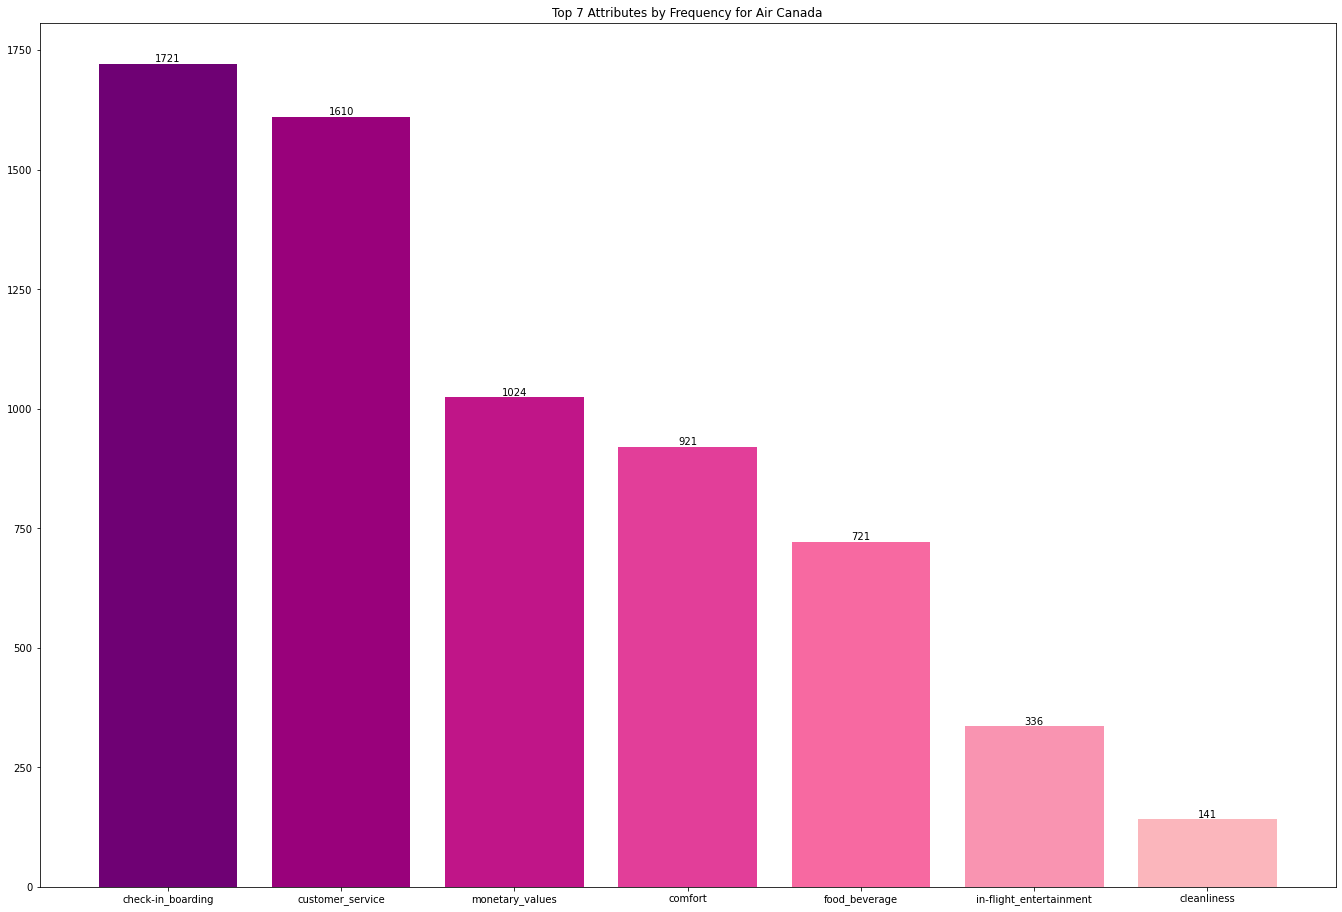

In [111]:
# bar plot of top 7 attributes for air_canada

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()    # initiate a figure
ax = fig.add_axes([2,2,3,3])    #  set up plot size and axes
k = ax.bar(air_canada_attri['attributes'],air_canada_attri['counts'],color = sns.color_palette('RdPu_r',9))    # bar plot
ax.bar_label(k)     # generate data labels at the top of each bar
plt.title('Top 7 Attributes by Frequency for Air Canada')
plt.show()

# 6. Test Classification

In [57]:

from sklearn.model_selection import StratifiedShuffleSplit
split=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=9)

train_idx = []
test_idx = []
for train_index, test_index in split.split(review['Review'],review['Airline']):
    train_idx.append(train_index)
    test_idx.append(test_index)

In [58]:
df_train=review.iloc[train_idx[0]]

In [59]:
train_idx

[array([ 8915, 13585, 11380, ..., 13140, 11456, 16858])]

In [69]:
df_train.iloc[1,1]

"This company was the worst experience I've ever had in my life. Customer service of them is horrible, the planes are a **. And another thing, they do not even have respect for the passengers. My aunt is now with my two children, a 5-year-old girl and a 3-year-old girl abandoned in Denver, who was scheduled to leave Florida for Reno, Nevada. I had to spend $1200 now to buy new tickets from Denver to Reno. This is disrespectful. A board for anyone who will read this review, never use this ** of FRONTIER AIRLINES."

In [151]:
from nltk.corpus import stopwords
stopwords1 = stopwords.words('english')
#stopwords1 = stopwords1+['delta','american','united','spirit','canada',
#                  'ryanair','frontier','emirates','southwest','british']

In [153]:
from sklearn.feature_extraction.text import TfidfVectorizer
#stopwords1 = stopwords.words('english')
#stopwords1.append(['delta','american','united','spirit','canada',
#                  'ryanair','frontier','emirates','southwest','british'])
vectorizer = TfidfVectorizer(stop_words=set(stopwords1))
X_train = vectorizer.fit_transform(df_train['Review'])

In [144]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words=set(stopwords1))
X_train = vectorizer.fit_transform(df_train['Review'])

In [154]:
X_train .shape
#vectorizer.vocabulary_.get(u'algorithm')

(16000, 24558)

In [189]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
model = SGDClassifier()
#model = MultinomialNB()
model.fit(X=X_train,y=df_train['Airline'])

SGDClassifier()

In [156]:
df_test = review.iloc[test_idx[0]]

In [157]:
X_test = vectorizer.transform(df_test['Review'])

In [158]:
y_pred=model.predict(X_test)

In [159]:
sum(y_pred == df_test['Airline'])/len(df_test['Airline'])

0.869

In [103]:
from sklearn.metrics import confusion_matrix,accuracy_score

In [166]:
list(set(y_pred))

['Delta_Airline',
 'Southwest_Airline',
 'United_Airline',
 'British_Airway',
 'Spirit_Airline',
 'American_Airline',
 'Air_Canada',
 'Frontier_Airline',
 'Ryanair',
 'Emirates_Airline']

In [160]:
confusion_matrix(df_test['Airline'],y_pred)

array([[374,   1,   4,   4,   2,   1,   2,   2,   2,   8],
       [  6, 316,   3,  18,   1,   6,   4,  13,  13,  20],
       [  3,   0, 383,   1,   4,   1,   6,   1,   0,   1],
       [  2,  16,   2, 343,   3,   4,   2,  13,   6,   9],
       [  0,   0,   1,   0, 394,   0,   2,   0,   0,   3],
       [  3,  23,   0,   8,   1, 293,   2,  20,  31,  19],
       [  1,   0,   5,   0,   0,   1, 392,   1,   0,   0],
       [  1,  10,   1,  11,   2,   5,   1, 347,  14,   8],
       [  4,  18,   0,  12,   1,  25,   3,  11, 314,  12],
       [  3,  23,   1,  17,   1,   8,   6,  17,   4, 320]])

<AxesSubplot:title={'center':'Confusion Matrix of Classification Result'}>

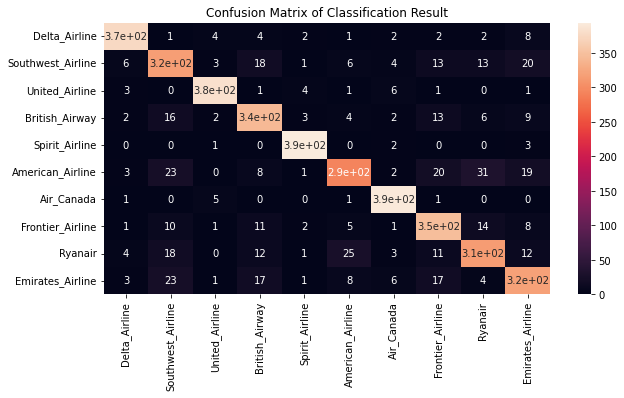

In [183]:
df_cm = pd.DataFrame(confusion_matrix(df_test['Airline'],y_pred), index = [i for i in list(set(y_pred))],
                  columns = [i for i in list(set(y_pred))])
plt.figure(figsize = (10,5))

plt.title('Confusion Matrix of Classification Result')
sns.heatmap(df_cm, annot=True)

In [161]:
accuracy_score(df_test['Airline'],y_pred)

0.869

In [7]:
pip install lda

     |████████████████████████████████| 320 kB 6.9 MB/s eta 0:00:01
     |████████████████████████████████| 99 kB 3.9 MB/s eta 0:00:01
  Created wheel for lda: filename=lda-2.0.0-cp39-cp39-macosx_10_9_x86_64.whl size=338900 sha256=43f4f69ef49627afd97f5b3e647759777c966fd81b0465f36c9d96b62513f523
  Stored in directory: /Users/ziyezhang/Library/Caches/pip/wheels/3d/b5/8f/1c1c6a2986ad87a19ddd0a0fbe676d6e4764b5c906702fdd95
Successfully built lda
Note: you may need to restart the kernel to use updated packages.


In [8]:
#!/usr/bin/env python3.0

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import lda
import pandas as pd
from nltk.tokenize import PunktSentenceTokenizer, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ziyezhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ziyezhang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
# uses default alpha and beta values
reviews_df=pd.read_csv("Airlines.csv")
reviews_df.columns

Index(['Airline', 'Review'], dtype='object')

In [15]:
#checking for nulls if present any
print("Number of rows with any of the empty columns:")
print(reviews_df.isnull().sum().sum())
reviews_df=reviews_df.dropna()

restaurant_name = input('provide the column name for airline names: ')
restaurant_review = input('provide the column name for airline reviews: ')
ntopics= input('Provide the number of latent topics to be estimated: ')

Number of rows with any of the empty columns:
0
provide the column name for airline names: Airline
provide the column name for airline reviews: Review
Provide the number of latent topics to be estimated: 3


In [16]:
word_tokenizer=RegexpTokenizer(r'\w+')
wordnet_lemmatizer = WordNetLemmatizer()
stopwords_nltk=set(stopwords.words('english'))
temp = reviews_df[restaurant_review]
def tokenize_text(version_desc):
    lowercase=version_desc.lower()
    text = wordnet_lemmatizer.lemmatize(lowercase)
    tokens = word_tokenizer.tokenize(text)
    return tokens

vec_words = CountVectorizer(tokenizer=tokenize_text,stop_words=stopwords_nltk,decode_error='ignore')
total_features_words = vec_words.fit_transform(reviews_df[restaurant_review])

print(total_features_words.shape)

model = lda.LDA(n_topics=int(ntopics), n_iter=500, random_state=1)
model.fit(total_features_words)

topic_word = model.topic_word_
doc_topic=model.doc_topic_
doc_topic=pd.DataFrame(doc_topic)
reviews_df=reviews_df.join(doc_topic)
restaurant=pd.DataFrame()

for i in range(int(ntopics)):
    topic="topic_"+str(i)
    restaurant[topic]=reviews_df.groupby([restaurant_name])[i].mean()

restaurant=restaurant.reset_index()
topics=pd.DataFrame(topic_word)
topics.columns=vec_words.get_feature_names()
topics1=topics.transpose()
topics1.to_excel("topic_word_dist.xlsx")
restaurant.to_excel("restaurant_topic_dist.xlsx",index=False)

INFO:lda:n_documents: 20000
INFO:lda:vocab_size: 27103
INFO:lda:n_words: 1281361
INFO:lda:n_topics: 3
INFO:lda:n_iter: 500


(20000, 27103)


INFO:lda:<0> log likelihood: -11409588
INFO:lda:<10> log likelihood: -10573603
INFO:lda:<20> log likelihood: -10196496
INFO:lda:<30> log likelihood: -10127750
INFO:lda:<40> log likelihood: -10095816
INFO:lda:<50> log likelihood: -10080873
INFO:lda:<60> log likelihood: -10072138
INFO:lda:<70> log likelihood: -10068163
INFO:lda:<80> log likelihood: -10062923
INFO:lda:<90> log likelihood: -10063088
INFO:lda:<100> log likelihood: -10059124
INFO:lda:<110> log likelihood: -10057919
INFO:lda:<120> log likelihood: -10056937
INFO:lda:<130> log likelihood: -10056168
INFO:lda:<140> log likelihood: -10057440
INFO:lda:<150> log likelihood: -10055975
INFO:lda:<160> log likelihood: -10055902
INFO:lda:<170> log likelihood: -10056352
INFO:lda:<180> log likelihood: -10054174
INFO:lda:<190> log likelihood: -10055681
INFO:lda:<200> log likelihood: -10056050
INFO:lda:<210> log likelihood: -10055784
INFO:lda:<220> log likelihood: -10054052
INFO:lda:<230> log likelihood: -10052616
INFO:lda:<240> log likeliho

In [17]:
reviews_df.Airline.value_counts()

Delta_Airline        2000
American_Airline     2000
United_Airline       2000
Spirit_Airline       2000
Air_Canada           2000
Ryanair              2000
Frontier_Airline     2000
Emirates_Airline     2000
Southwest_Airline    2000
British_Airway       2000
Name: Airline, dtype: int64